In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utilsfc import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_CAAE_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 50
batch_size = 50
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn(batch_size, prior_size).to(device)
#fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data,_ = next(iter(test_loader))
fixed_data = fixed_data[:batch_size].to(device)
#fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cpu


In [6]:
data, label = next(iter(train_loader))

In [7]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [8]:
Enc = FullyConnected([28*28, 500, 501, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size, 500, 501, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size, 500, 501, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [9]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [10]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [11]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        #label = to_onehot(label, 10, device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        #z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)

        fake_pred = Disc(Enc(data))
        true_pred = Disc(z)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        #z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10)
        
        latent = Enc(data)
        reconstructed = Dec(latent).view(-1, 1, 28, 28)
        fake_pred = Disc(latent)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [12]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
           # label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            #z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc(data)
            reconstructed = Dec(latent).view(-1, 1, 28, 28)
            fake_pred = Disc(latent)
            true_pred = Disc(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        fixed_gen = Dec(fixed_z).cpu().data.numpy().reshape(50, 1, 28, 28)
        plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec(Enc(fixed_data)).cpu().data.numpy().reshape(50, 1, 28, 28)
        plot_mnist(fixed_reconstruction, (5, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.7043, AE: 0.9249, D: 0.6853
Train Epoch: 1 [5000/50000 (10%)]	Losses E: 0.1921, AE: 0.3009, D: 2.4379
Train Epoch: 1 [10000/50000 (20%)]	Losses E: 3.2468, AE: 0.3142, D: 1.0498
Train Epoch: 1 [15000/50000 (30%)]	Losses E: 0.7712, AE: 0.2699, D: 0.9647
Train Epoch: 1 [20000/50000 (40%)]	Losses E: 0.6959, AE: 0.2622, D: 0.8228
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 0.8026, AE: 0.2606, D: 0.7606
Train Epoch: 1 [30000/50000 (60%)]	Losses E: 0.7793, AE: 0.2605, D: 0.8107
Train Epoch: 1 [35000/50000 (70%)]	Losses E: 0.6364, AE: 0.2744, D: 0.7778
Train Epoch: 1 [40000/50000 (80%)]	Losses E: 0.6076, AE: 0.2841, D: 0.7292
Train Epoch: 1 [45000/50000 (90%)]	Losses E: 0.9278, AE: 0.2536, D: 0.6879
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.7706, AE: 0.2575, D: 0.7512


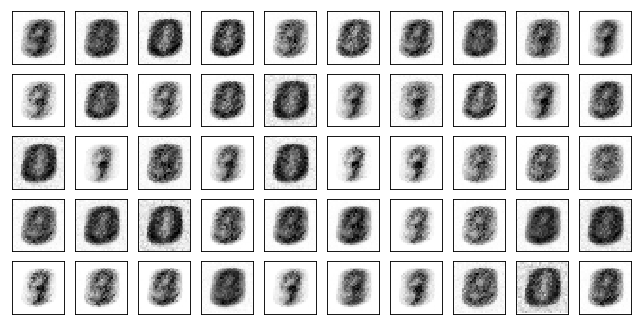

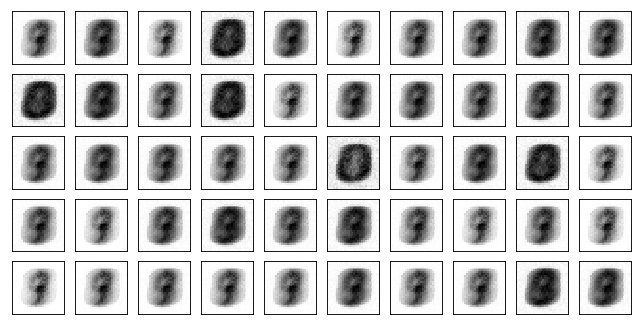

Test losses. E: 0.7578, AE: 0.2548, D: 0.7424
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.7675, AE: 0.2478, D: 0.7493
Train Epoch: 2 [5000/50000 (10%)]	Losses E: 0.6771, AE: 0.2411, D: 0.7176
Train Epoch: 2 [10000/50000 (20%)]	Losses E: 0.6196, AE: 0.2476, D: 0.7093
Train Epoch: 2 [15000/50000 (30%)]	Losses E: 0.6467, AE: 0.2363, D: 0.7291
Train Epoch: 2 [20000/50000 (40%)]	Losses E: 0.6413, AE: 0.2460, D: 0.7238
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.6277, AE: 0.2303, D: 0.7336
Train Epoch: 2 [30000/50000 (60%)]	Losses E: 0.8279, AE: 0.2418, D: 0.6808
Train Epoch: 2 [35000/50000 (70%)]	Losses E: 0.6127, AE: 0.2376, D: 0.7300
Train Epoch: 2 [40000/50000 (80%)]	Losses E: 0.6373, AE: 0.2409, D: 0.7050
Train Epoch: 2 [45000/50000 (90%)]	Losses E: 0.7441, AE: 0.2518, D: 0.6664
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 0.7233, AE: 0.2172, D: 0.7721


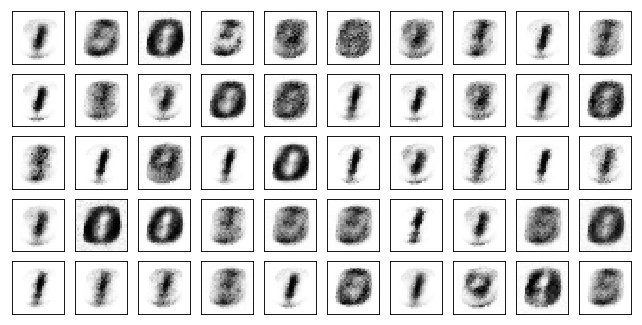

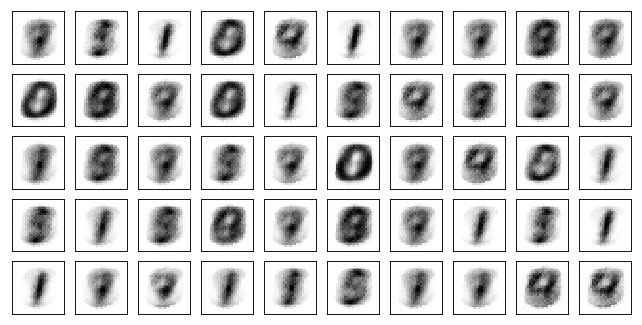

Test losses. E: 0.7066, AE: 0.2328, D: 0.7616
Train Epoch: 3 [0/50000 (0%)]	Losses E: 0.7221, AE: 0.2144, D: 0.7674
Train Epoch: 3 [5000/50000 (10%)]	Losses E: 0.6727, AE: 0.2200, D: 0.7272
Train Epoch: 3 [10000/50000 (20%)]	Losses E: 0.6719, AE: 0.2351, D: 0.6861
Train Epoch: 3 [15000/50000 (30%)]	Losses E: 0.6467, AE: 0.2153, D: 0.7583
Train Epoch: 3 [20000/50000 (40%)]	Losses E: 0.6980, AE: 0.2189, D: 0.7498
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.6622, AE: 0.2197, D: 0.7047
Train Epoch: 3 [30000/50000 (60%)]	Losses E: 0.6387, AE: 0.2256, D: 0.6829
Train Epoch: 3 [35000/50000 (70%)]	Losses E: 0.8675, AE: 0.2112, D: 0.6733
Train Epoch: 3 [40000/50000 (80%)]	Losses E: 0.6844, AE: 0.2154, D: 0.7326
Train Epoch: 3 [45000/50000 (90%)]	Losses E: 0.6733, AE: 0.2127, D: 0.7002
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.6337, AE: 0.2000, D: 0.6876


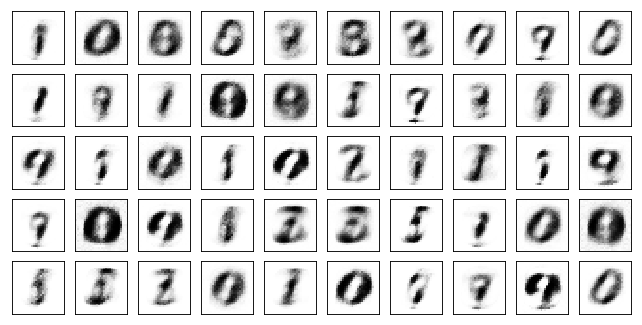

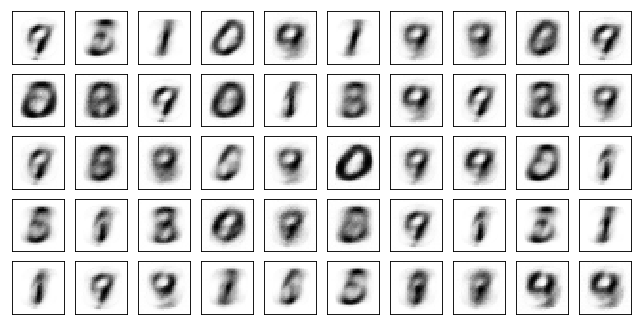

Test losses. E: 0.6327, AE: 0.2016, D: 0.6906
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.6353, AE: 0.2057, D: 0.6864
Train Epoch: 4 [5000/50000 (10%)]	Losses E: 0.6730, AE: 0.2048, D: 0.7676
Train Epoch: 4 [10000/50000 (20%)]	Losses E: 0.6857, AE: 0.1844, D: 0.7137
Train Epoch: 4 [15000/50000 (30%)]	Losses E: 0.6494, AE: 0.1818, D: 0.6975
Train Epoch: 4 [20000/50000 (40%)]	Losses E: 0.6085, AE: 0.1919, D: 0.7311
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.8055, AE: 0.1952, D: 0.6803
Train Epoch: 4 [30000/50000 (60%)]	Losses E: 0.6819, AE: 0.1711, D: 0.7130
Train Epoch: 4 [35000/50000 (70%)]	Losses E: 0.6587, AE: 0.1680, D: 0.6869
Train Epoch: 4 [40000/50000 (80%)]	Losses E: 0.5665, AE: 0.1876, D: 0.7538
Train Epoch: 4 [45000/50000 (90%)]	Losses E: 0.7297, AE: 0.1711, D: 0.7556
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.6834, AE: 0.1543, D: 0.7057


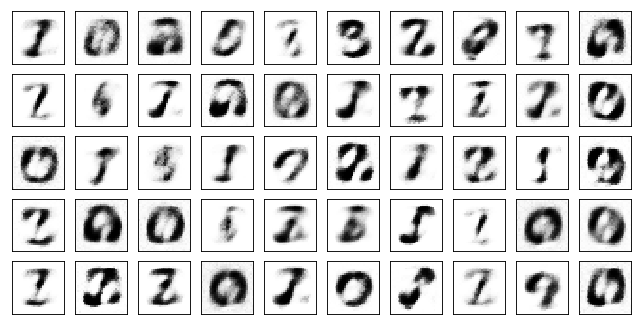

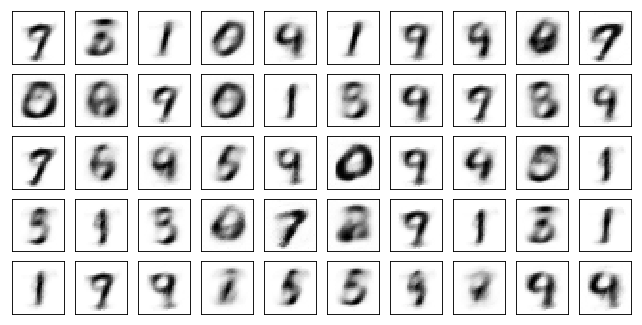

Test losses. E: 0.6868, AE: 0.1649, D: 0.7007
Train Epoch: 5 [0/50000 (0%)]	Losses E: 0.6858, AE: 0.1671, D: 0.7003
Train Epoch: 5 [5000/50000 (10%)]	Losses E: 0.6796, AE: 0.1662, D: 0.6867
Train Epoch: 5 [10000/50000 (20%)]	Losses E: 0.7619, AE: 0.2058, D: 0.7089
Train Epoch: 5 [15000/50000 (30%)]	Losses E: 0.7094, AE: 0.1536, D: 0.7077
Train Epoch: 5 [20000/50000 (40%)]	Losses E: 0.6541, AE: 0.1684, D: 0.6878
Train Epoch: 5 [25000/50000 (50%)]	Losses E: 0.6494, AE: 0.1655, D: 0.7496
Train Epoch: 5 [30000/50000 (60%)]	Losses E: 0.6830, AE: 0.1427, D: 0.7147
Train Epoch: 5 [35000/50000 (70%)]	Losses E: 0.6711, AE: 0.1255, D: 0.6906
Train Epoch: 5 [40000/50000 (80%)]	Losses E: 0.8411, AE: 0.1615, D: 0.6349
Train Epoch: 5 [45000/50000 (90%)]	Losses E: 0.7195, AE: 0.1573, D: 0.7223
Train Epoch: 5 [50000/50000 (100%)]	Losses E: 0.6736, AE: 0.1370, D: 0.6977


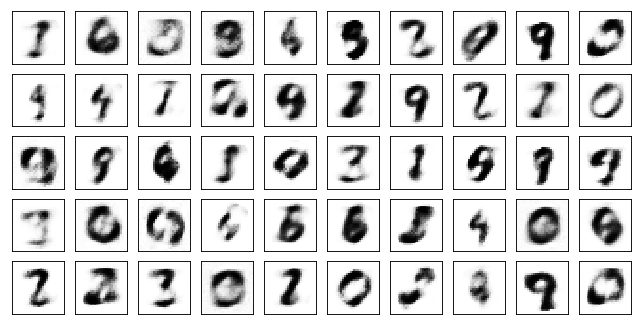

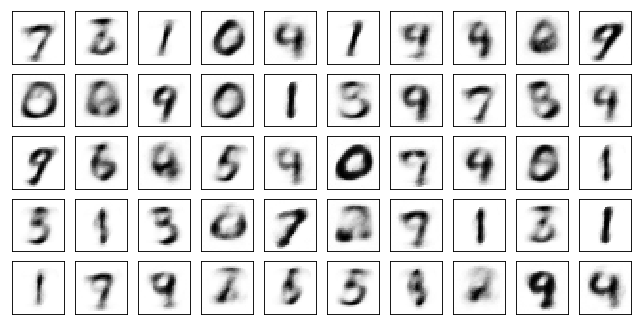

Test losses. E: 0.6731, AE: 0.1384, D: 0.6954
Train Epoch: 6 [0/50000 (0%)]	Losses E: 0.6699, AE: 0.1262, D: 0.6949
Train Epoch: 6 [5000/50000 (10%)]	Losses E: 0.6506, AE: 0.1480, D: 0.6962
Train Epoch: 6 [10000/50000 (20%)]	Losses E: 0.8061, AE: 0.1392, D: 0.6637
Train Epoch: 6 [15000/50000 (30%)]	Losses E: 0.7012, AE: 0.1315, D: 0.7083
Train Epoch: 6 [20000/50000 (40%)]	Losses E: 0.6716, AE: 0.1173, D: 0.6915
Train Epoch: 6 [25000/50000 (50%)]	Losses E: 0.7067, AE: 0.1413, D: 0.6894
Train Epoch: 6 [30000/50000 (60%)]	Losses E: 0.7035, AE: 0.1331, D: 0.6945
Train Epoch: 6 [35000/50000 (70%)]	Losses E: 0.7006, AE: 0.1230, D: 0.6971
Train Epoch: 6 [40000/50000 (80%)]	Losses E: 0.6802, AE: 0.1185, D: 0.6999
Train Epoch: 6 [45000/50000 (90%)]	Losses E: 0.6586, AE: 0.1153, D: 0.7015
Train Epoch: 6 [50000/50000 (100%)]	Losses E: 0.6783, AE: 0.1205, D: 0.7081


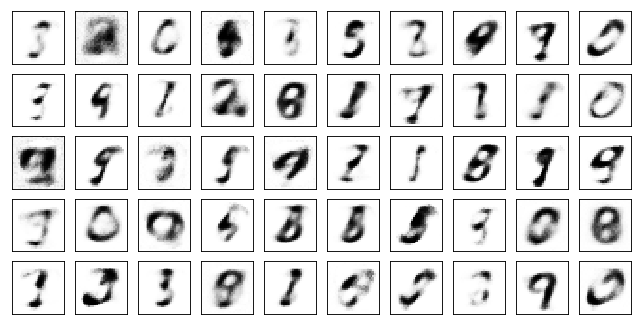

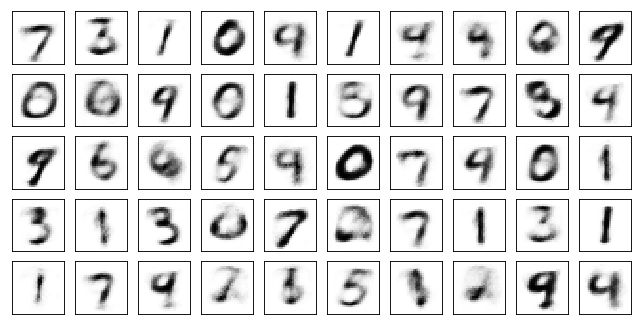

Test losses. E: 0.6785, AE: 0.1244, D: 0.7061
Train Epoch: 7 [0/50000 (0%)]	Losses E: 0.6784, AE: 0.1366, D: 0.7069
Train Epoch: 7 [5000/50000 (10%)]	Losses E: 0.7064, AE: 0.1149, D: 0.6917
Train Epoch: 7 [10000/50000 (20%)]	Losses E: 0.7309, AE: 0.1249, D: 0.6858
Train Epoch: 7 [15000/50000 (30%)]	Losses E: 0.7116, AE: 0.1255, D: 0.6994
Train Epoch: 7 [20000/50000 (40%)]	Losses E: 0.7005, AE: 0.1259, D: 0.6966
Train Epoch: 7 [25000/50000 (50%)]	Losses E: 0.6762, AE: 0.1086, D: 0.6978
Train Epoch: 7 [30000/50000 (60%)]	Losses E: 0.6531, AE: 0.1059, D: 0.7064
Train Epoch: 7 [35000/50000 (70%)]	Losses E: 0.6895, AE: 0.1053, D: 0.7056
Train Epoch: 7 [40000/50000 (80%)]	Losses E: 0.6836, AE: 0.1005, D: 0.6891
Train Epoch: 7 [45000/50000 (90%)]	Losses E: 0.7244, AE: 0.1150, D: 0.6851
Train Epoch: 7 [50000/50000 (100%)]	Losses E: 0.7066, AE: 0.1015, D: 0.6916


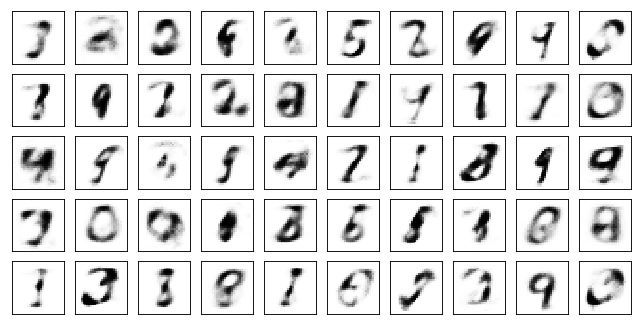

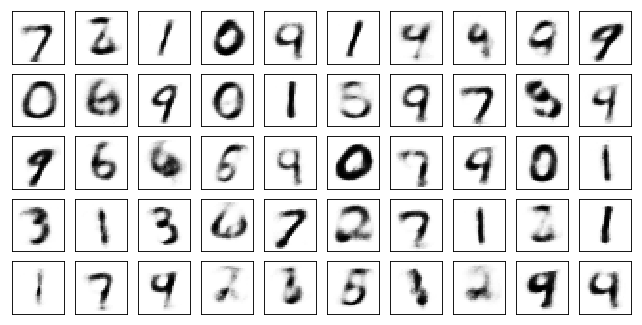

Test losses. E: 0.7024, AE: 0.1098, D: 0.6913
Train Epoch: 8 [0/50000 (0%)]	Losses E: 0.7071, AE: 0.1012, D: 0.6869
Train Epoch: 8 [5000/50000 (10%)]	Losses E: 0.7478, AE: 0.1064, D: 0.6834
Train Epoch: 8 [10000/50000 (20%)]	Losses E: 0.6545, AE: 0.1093, D: 0.7065
Train Epoch: 8 [15000/50000 (30%)]	Losses E: 0.6858, AE: 0.0968, D: 0.6970
Train Epoch: 8 [20000/50000 (40%)]	Losses E: 0.7016, AE: 0.1045, D: 0.6911
Train Epoch: 8 [25000/50000 (50%)]	Losses E: 0.6759, AE: 0.1107, D: 0.7055
Train Epoch: 8 [30000/50000 (60%)]	Losses E: 0.6807, AE: 0.1122, D: 0.7035
Train Epoch: 8 [35000/50000 (70%)]	Losses E: 0.6892, AE: 0.1022, D: 0.6944
Train Epoch: 8 [40000/50000 (80%)]	Losses E: 0.6947, AE: 0.1022, D: 0.6855
Train Epoch: 8 [45000/50000 (90%)]	Losses E: 0.7271, AE: 0.0999, D: 0.7035
Train Epoch: 8 [50000/50000 (100%)]	Losses E: 0.6448, AE: 0.1027, D: 0.7061


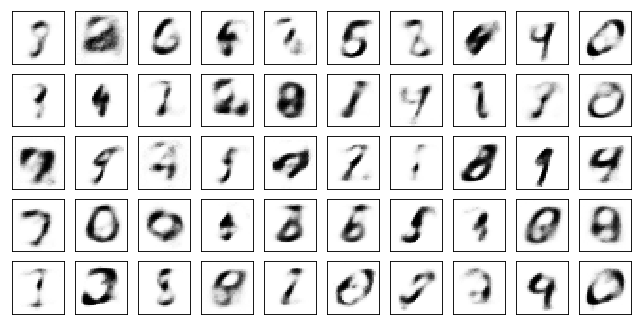

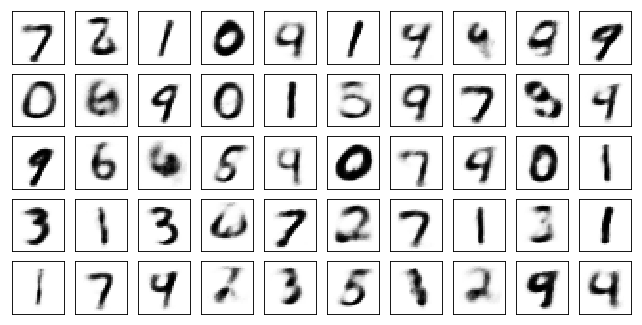

Test losses. E: 0.6480, AE: 0.1040, D: 0.7025
Train Epoch: 9 [0/50000 (0%)]	Losses E: 0.6526, AE: 0.1037, D: 0.6988
Train Epoch: 9 [5000/50000 (10%)]	Losses E: 0.6855, AE: 0.0913, D: 0.7012
Train Epoch: 9 [10000/50000 (20%)]	Losses E: 0.6632, AE: 0.0979, D: 0.7004
Train Epoch: 9 [15000/50000 (30%)]	Losses E: 0.6914, AE: 0.1094, D: 0.6999
Train Epoch: 9 [20000/50000 (40%)]	Losses E: 0.6793, AE: 0.1125, D: 0.6987
Train Epoch: 9 [25000/50000 (50%)]	Losses E: 0.6692, AE: 0.0927, D: 0.6957
Train Epoch: 9 [30000/50000 (60%)]	Losses E: 0.6820, AE: 0.1013, D: 0.7008
Train Epoch: 9 [35000/50000 (70%)]	Losses E: 0.6779, AE: 0.0945, D: 0.6906
Train Epoch: 9 [40000/50000 (80%)]	Losses E: 0.7239, AE: 0.1083, D: 0.6919
Train Epoch: 9 [45000/50000 (90%)]	Losses E: 0.6787, AE: 0.0853, D: 0.6931
Train Epoch: 9 [50000/50000 (100%)]	Losses E: 0.6736, AE: 0.1027, D: 0.6956


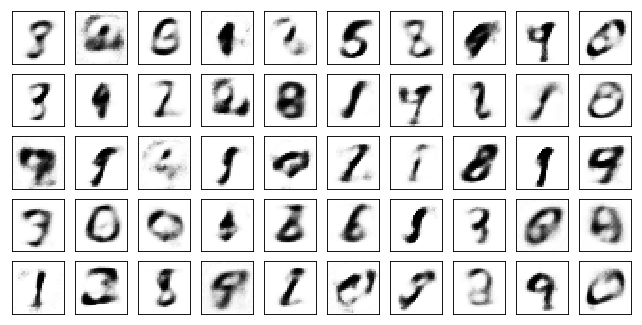

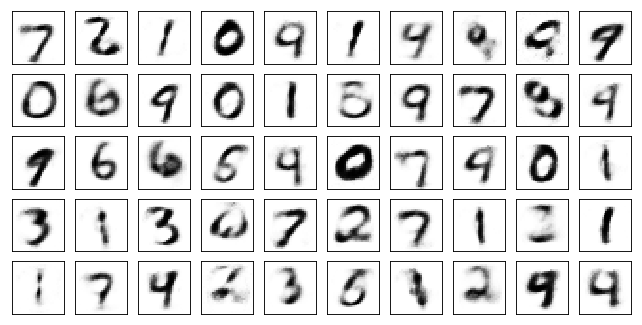

Test losses. E: 0.6622, AE: 0.1043, D: 0.7005
Train Epoch: 10 [0/50000 (0%)]	Losses E: 0.6650, AE: 0.1083, D: 0.7013
Train Epoch: 10 [5000/50000 (10%)]	Losses E: 0.6602, AE: 0.1062, D: 0.6982
Train Epoch: 10 [10000/50000 (20%)]	Losses E: 0.6901, AE: 0.0916, D: 0.6898
Train Epoch: 10 [15000/50000 (30%)]	Losses E: 0.6866, AE: 0.0885, D: 0.7013
Train Epoch: 10 [20000/50000 (40%)]	Losses E: 0.6685, AE: 0.1030, D: 0.7020
Train Epoch: 10 [25000/50000 (50%)]	Losses E: 0.6863, AE: 0.0945, D: 0.6965
Train Epoch: 10 [30000/50000 (60%)]	Losses E: 0.7060, AE: 0.1047, D: 0.6898
Train Epoch: 10 [35000/50000 (70%)]	Losses E: 0.6848, AE: 0.0741, D: 0.6926
Train Epoch: 10 [40000/50000 (80%)]	Losses E: 0.7078, AE: 0.0940, D: 0.6939
Train Epoch: 10 [45000/50000 (90%)]	Losses E: 0.6784, AE: 0.1008, D: 0.6954
Train Epoch: 10 [50000/50000 (100%)]	Losses E: 0.6887, AE: 0.0862, D: 0.6919


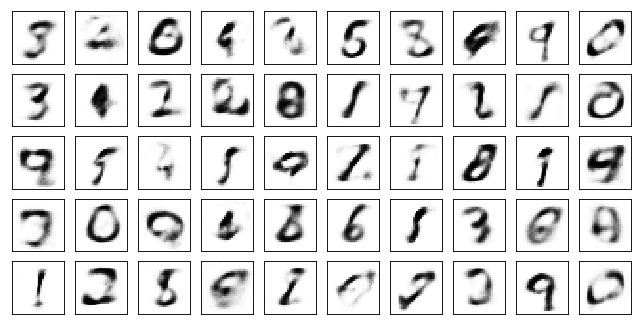

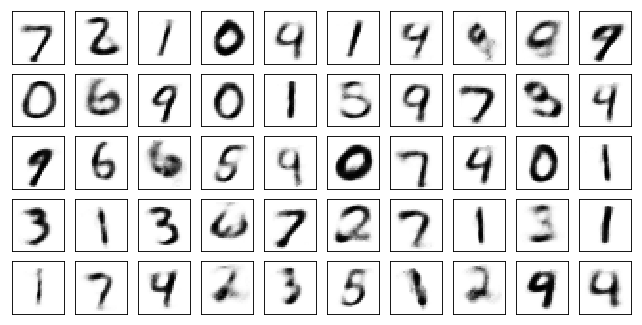

Test losses. E: 0.6896, AE: 0.0868, D: 0.6925
Train Epoch: 11 [0/50000 (0%)]	Losses E: 0.6889, AE: 0.0842, D: 0.6914
Train Epoch: 11 [5000/50000 (10%)]	Losses E: 0.7027, AE: 0.0934, D: 0.6944
Train Epoch: 11 [10000/50000 (20%)]	Losses E: 0.6748, AE: 0.0956, D: 0.6936
Train Epoch: 11 [15000/50000 (30%)]	Losses E: 0.6949, AE: 0.0873, D: 0.6928
Train Epoch: 11 [20000/50000 (40%)]	Losses E: 0.7009, AE: 0.0894, D: 0.6932
Train Epoch: 11 [25000/50000 (50%)]	Losses E: 0.6791, AE: 0.0831, D: 0.6936
Train Epoch: 11 [30000/50000 (60%)]	Losses E: 0.6960, AE: 0.0893, D: 0.6934
Train Epoch: 11 [35000/50000 (70%)]	Losses E: 0.6976, AE: 0.0827, D: 0.6922
Train Epoch: 11 [40000/50000 (80%)]	Losses E: 0.6934, AE: 0.0877, D: 0.6953
Train Epoch: 11 [45000/50000 (90%)]	Losses E: 0.6941, AE: 0.0822, D: 0.6951
Train Epoch: 11 [50000/50000 (100%)]	Losses E: 0.6924, AE: 0.0830, D: 0.6960


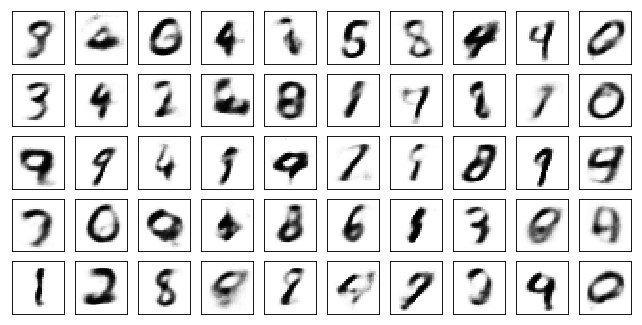

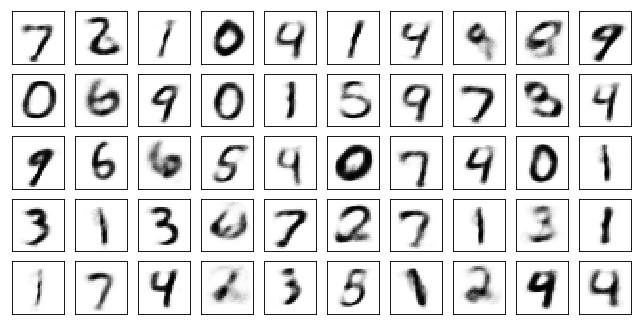

Test losses. E: 0.6930, AE: 0.0832, D: 0.6938
Train Epoch: 12 [0/50000 (0%)]	Losses E: 0.6956, AE: 0.0828, D: 0.6963
Train Epoch: 12 [5000/50000 (10%)]	Losses E: 0.6897, AE: 0.0644, D: 0.6919
Train Epoch: 12 [10000/50000 (20%)]	Losses E: 0.7067, AE: 0.0898, D: 0.6936
Train Epoch: 12 [15000/50000 (30%)]	Losses E: 0.6941, AE: 0.0757, D: 0.6898
Train Epoch: 12 [20000/50000 (40%)]	Losses E: 0.6945, AE: 0.0714, D: 0.6945
Train Epoch: 12 [25000/50000 (50%)]	Losses E: 0.6921, AE: 0.0795, D: 0.6977
Train Epoch: 12 [30000/50000 (60%)]	Losses E: 0.6988, AE: 0.0840, D: 0.6915
Train Epoch: 12 [35000/50000 (70%)]	Losses E: 0.6974, AE: 0.0881, D: 0.6946
Train Epoch: 12 [40000/50000 (80%)]	Losses E: 0.7054, AE: 0.0786, D: 0.6927
Train Epoch: 12 [45000/50000 (90%)]	Losses E: 0.6901, AE: 0.0737, D: 0.6932
Train Epoch: 12 [50000/50000 (100%)]	Losses E: 0.6851, AE: 0.0913, D: 0.6953


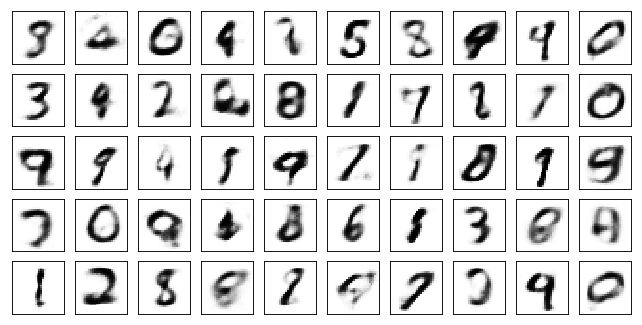

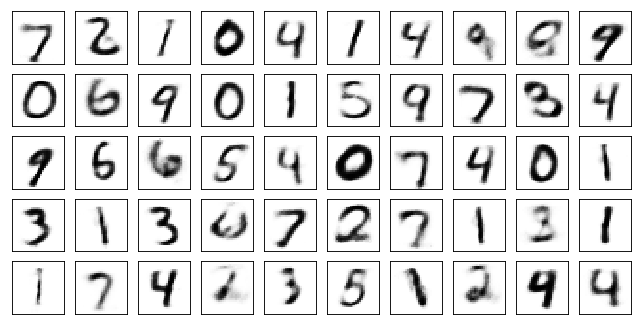

Test losses. E: 0.6862, AE: 0.0771, D: 0.6939
Train Epoch: 13 [0/50000 (0%)]	Losses E: 0.6888, AE: 0.0877, D: 0.6922
Train Epoch: 13 [5000/50000 (10%)]	Losses E: 0.7033, AE: 0.0743, D: 0.6932
Train Epoch: 13 [10000/50000 (20%)]	Losses E: 0.6846, AE: 0.0852, D: 0.6922
Train Epoch: 13 [15000/50000 (30%)]	Losses E: 0.7048, AE: 0.0662, D: 0.6932
Train Epoch: 13 [20000/50000 (40%)]	Losses E: 0.7051, AE: 0.0758, D: 0.6892
Train Epoch: 13 [25000/50000 (50%)]	Losses E: 0.6866, AE: 0.0721, D: 0.6947
Train Epoch: 13 [30000/50000 (60%)]	Losses E: 0.7003, AE: 0.0632, D: 0.6939
Train Epoch: 13 [35000/50000 (70%)]	Losses E: 0.6871, AE: 0.0793, D: 0.6939
Train Epoch: 13 [40000/50000 (80%)]	Losses E: 0.6929, AE: 0.0803, D: 0.6933
Train Epoch: 13 [45000/50000 (90%)]	Losses E: 0.6898, AE: 0.0774, D: 0.6953
Train Epoch: 13 [50000/50000 (100%)]	Losses E: 0.6772, AE: 0.0693, D: 0.6966


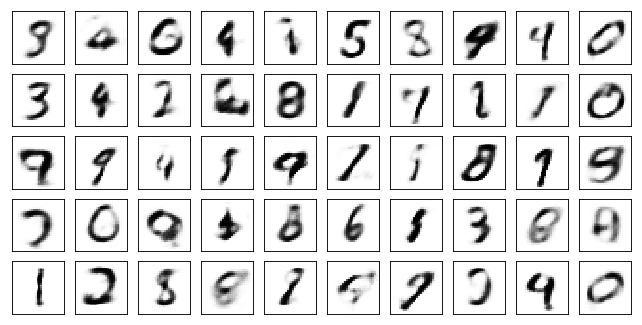

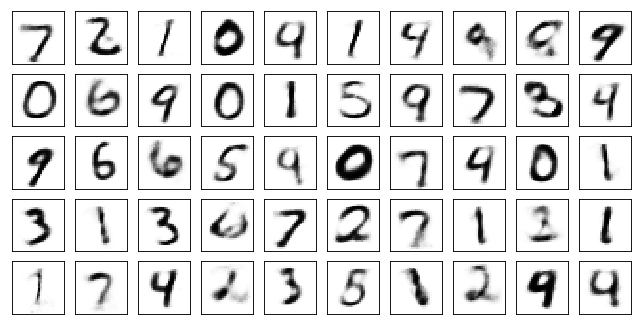

Test losses. E: 0.6761, AE: 0.0773, D: 0.6957
Train Epoch: 14 [0/50000 (0%)]	Losses E: 0.6745, AE: 0.0867, D: 0.6975
Train Epoch: 14 [5000/50000 (10%)]	Losses E: 0.6921, AE: 0.0786, D: 0.6920
Train Epoch: 14 [10000/50000 (20%)]	Losses E: 0.6936, AE: 0.0727, D: 0.6909
Train Epoch: 14 [15000/50000 (30%)]	Losses E: 0.6966, AE: 0.0774, D: 0.6942
Train Epoch: 14 [20000/50000 (40%)]	Losses E: 0.6945, AE: 0.0833, D: 0.6912
Train Epoch: 14 [25000/50000 (50%)]	Losses E: 0.6897, AE: 0.0755, D: 0.6933
Train Epoch: 14 [30000/50000 (60%)]	Losses E: 0.6884, AE: 0.0675, D: 0.6920
Train Epoch: 14 [35000/50000 (70%)]	Losses E: 0.6932, AE: 0.0692, D: 0.6931
Train Epoch: 14 [40000/50000 (80%)]	Losses E: 0.6853, AE: 0.0676, D: 0.6945
Train Epoch: 14 [45000/50000 (90%)]	Losses E: 0.6862, AE: 0.0827, D: 0.6953
Train Epoch: 14 [50000/50000 (100%)]	Losses E: 0.6964, AE: 0.0650, D: 0.6952


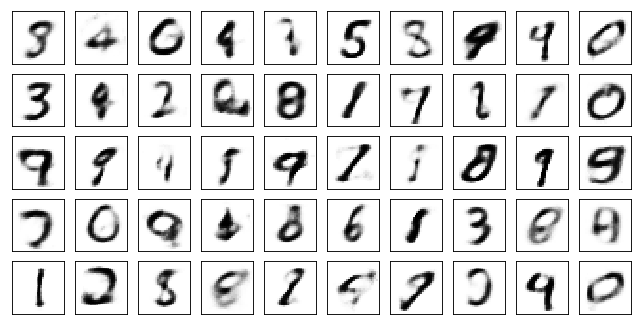

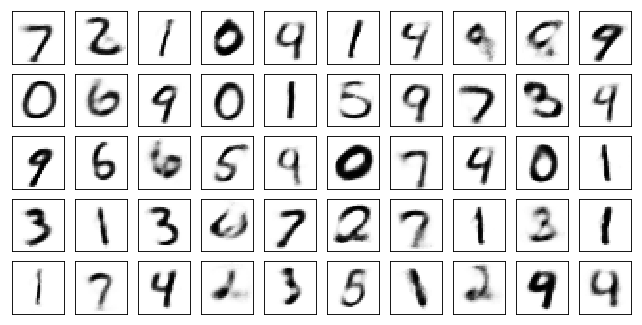

Test losses. E: 0.6944, AE: 0.0749, D: 0.6942
Train Epoch: 15 [0/50000 (0%)]	Losses E: 0.6935, AE: 0.0790, D: 0.6971
Train Epoch: 15 [5000/50000 (10%)]	Losses E: 0.6902, AE: 0.0653, D: 0.6916
Train Epoch: 15 [10000/50000 (20%)]	Losses E: 0.6982, AE: 0.0749, D: 0.6943
Train Epoch: 15 [15000/50000 (30%)]	Losses E: 0.6963, AE: 0.0735, D: 0.6922
Train Epoch: 15 [20000/50000 (40%)]	Losses E: 0.7059, AE: 0.0724, D: 0.6900
Train Epoch: 15 [25000/50000 (50%)]	Losses E: 0.6911, AE: 0.0644, D: 0.6947
Train Epoch: 15 [30000/50000 (60%)]	Losses E: 0.6978, AE: 0.0765, D: 0.6922
Train Epoch: 15 [35000/50000 (70%)]	Losses E: 0.6804, AE: 0.0674, D: 0.6896
Train Epoch: 15 [40000/50000 (80%)]	Losses E: 0.6902, AE: 0.0751, D: 0.6972
Train Epoch: 15 [45000/50000 (90%)]	Losses E: 0.6912, AE: 0.0674, D: 0.6937
Train Epoch: 15 [50000/50000 (100%)]	Losses E: 0.6838, AE: 0.0684, D: 0.6947


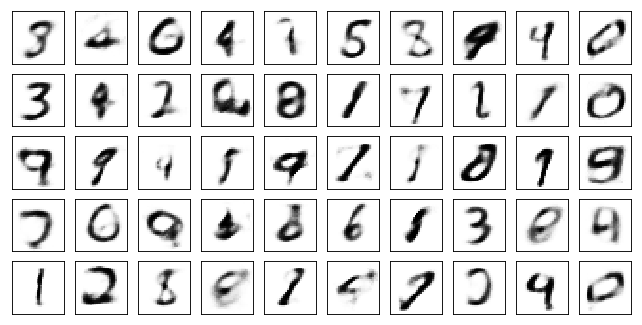

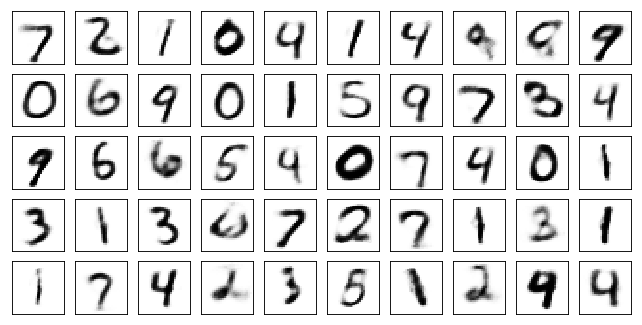

Test losses. E: 0.6853, AE: 0.0724, D: 0.6929
Train Epoch: 16 [0/50000 (0%)]	Losses E: 0.6875, AE: 0.0678, D: 0.6914
Train Epoch: 16 [5000/50000 (10%)]	Losses E: 0.6898, AE: 0.0700, D: 0.6913
Train Epoch: 16 [10000/50000 (20%)]	Losses E: 0.7000, AE: 0.0632, D: 0.6920
Train Epoch: 16 [15000/50000 (30%)]	Losses E: 0.6810, AE: 0.0704, D: 0.6956
Train Epoch: 16 [20000/50000 (40%)]	Losses E: 0.6844, AE: 0.0710, D: 0.6993
Train Epoch: 16 [25000/50000 (50%)]	Losses E: 0.6978, AE: 0.0643, D: 0.6949
Train Epoch: 16 [30000/50000 (60%)]	Losses E: 0.7070, AE: 0.0733, D: 0.6943
Train Epoch: 16 [35000/50000 (70%)]	Losses E: 0.6955, AE: 0.0702, D: 0.6942
Train Epoch: 16 [40000/50000 (80%)]	Losses E: 0.6957, AE: 0.0851, D: 0.6932
Train Epoch: 16 [45000/50000 (90%)]	Losses E: 0.7047, AE: 0.0771, D: 0.6948
Train Epoch: 16 [50000/50000 (100%)]	Losses E: 0.7097, AE: 0.0631, D: 0.6954


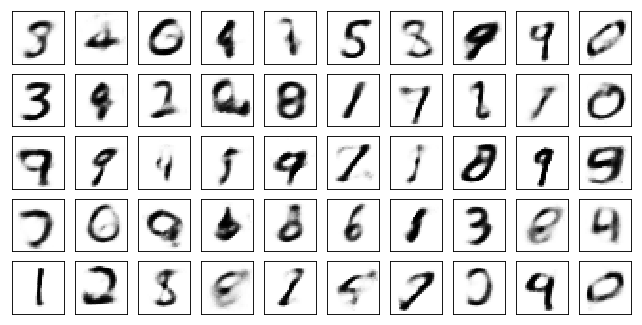

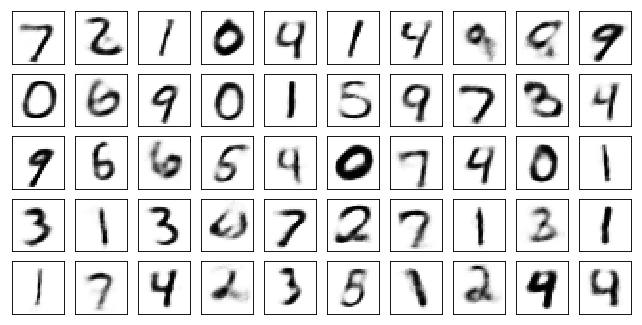

Test losses. E: 0.7047, AE: 0.0704, D: 0.6917
Train Epoch: 17 [0/50000 (0%)]	Losses E: 0.7100, AE: 0.0597, D: 0.6945
Train Epoch: 17 [5000/50000 (10%)]	Losses E: 0.6872, AE: 0.0671, D: 0.6938
Train Epoch: 17 [10000/50000 (20%)]	Losses E: 0.6931, AE: 0.0693, D: 0.6921
Train Epoch: 17 [15000/50000 (30%)]	Losses E: 0.6929, AE: 0.0748, D: 0.6950
Train Epoch: 17 [20000/50000 (40%)]	Losses E: 0.6881, AE: 0.0662, D: 0.6900
Train Epoch: 17 [25000/50000 (50%)]	Losses E: 0.6902, AE: 0.0678, D: 0.6952
Train Epoch: 17 [30000/50000 (60%)]	Losses E: 0.6987, AE: 0.0654, D: 0.6919
Train Epoch: 17 [35000/50000 (70%)]	Losses E: 0.7047, AE: 0.0752, D: 0.6948
Train Epoch: 17 [40000/50000 (80%)]	Losses E: 0.6912, AE: 0.0827, D: 0.6912
Train Epoch: 17 [45000/50000 (90%)]	Losses E: 0.6883, AE: 0.0702, D: 0.6966
Train Epoch: 17 [50000/50000 (100%)]	Losses E: 0.6816, AE: 0.0752, D: 0.6899


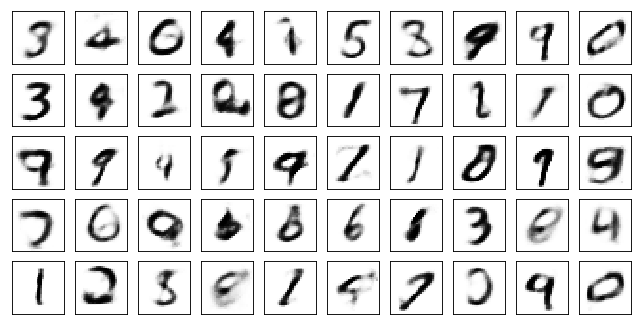

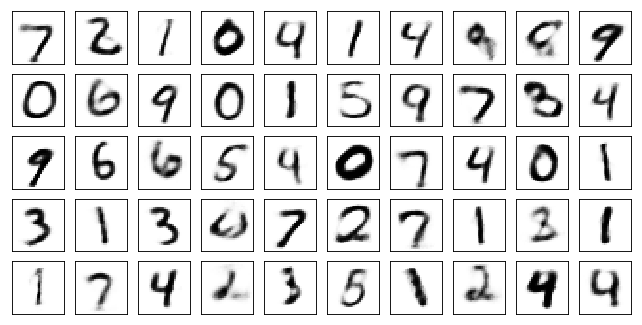

Test losses. E: 0.6873, AE: 0.0697, D: 0.6918
Train Epoch: 18 [0/50000 (0%)]	Losses E: 0.6892, AE: 0.0692, D: 0.6892
Train Epoch: 18 [5000/50000 (10%)]	Losses E: 0.6959, AE: 0.0645, D: 0.6951
Train Epoch: 18 [10000/50000 (20%)]	Losses E: 0.7004, AE: 0.0617, D: 0.6903
Train Epoch: 18 [15000/50000 (30%)]	Losses E: 0.6831, AE: 0.0660, D: 0.6973
Train Epoch: 18 [20000/50000 (40%)]	Losses E: 0.6929, AE: 0.0764, D: 0.6989
Train Epoch: 18 [25000/50000 (50%)]	Losses E: 0.7072, AE: 0.0672, D: 0.6909
Train Epoch: 18 [30000/50000 (60%)]	Losses E: 0.6818, AE: 0.0635, D: 0.6923
Train Epoch: 18 [35000/50000 (70%)]	Losses E: 0.6851, AE: 0.0602, D: 0.6901
Train Epoch: 18 [40000/50000 (80%)]	Losses E: 0.6886, AE: 0.0723, D: 0.6939
Train Epoch: 18 [45000/50000 (90%)]	Losses E: 0.6903, AE: 0.0617, D: 0.6962
Train Epoch: 18 [50000/50000 (100%)]	Losses E: 0.6903, AE: 0.0704, D: 0.6941


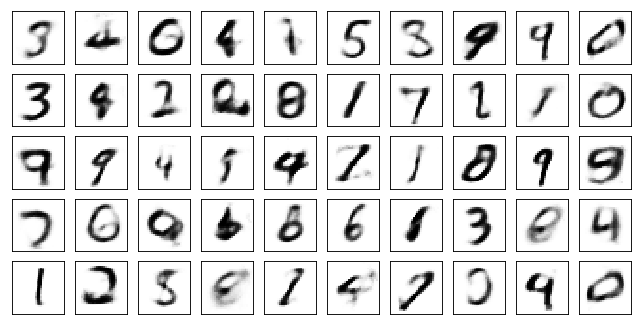

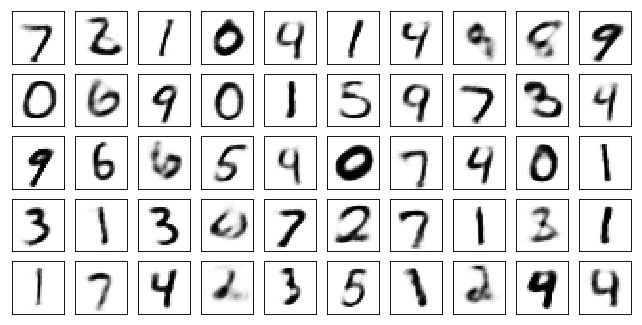

Test losses. E: 0.6820, AE: 0.0688, D: 0.6930
Train Epoch: 19 [0/50000 (0%)]	Losses E: 0.6760, AE: 0.0590, D: 0.6976
Train Epoch: 19 [5000/50000 (10%)]	Losses E: 0.6921, AE: 0.0726, D: 0.6915
Train Epoch: 19 [10000/50000 (20%)]	Losses E: 0.7034, AE: 0.0794, D: 0.6946
Train Epoch: 19 [15000/50000 (30%)]	Losses E: 0.6763, AE: 0.0636, D: 0.6941
Train Epoch: 19 [20000/50000 (40%)]	Losses E: 0.6800, AE: 0.0747, D: 0.7012
Train Epoch: 19 [25000/50000 (50%)]	Losses E: 0.6965, AE: 0.0725, D: 0.6957
Train Epoch: 19 [30000/50000 (60%)]	Losses E: 0.6897, AE: 0.0640, D: 0.6952
Train Epoch: 19 [35000/50000 (70%)]	Losses E: 0.6917, AE: 0.0815, D: 0.6939
Train Epoch: 19 [40000/50000 (80%)]	Losses E: 0.6895, AE: 0.0676, D: 0.6987
Train Epoch: 19 [45000/50000 (90%)]	Losses E: 0.7042, AE: 0.0773, D: 0.6966
Train Epoch: 19 [50000/50000 (100%)]	Losses E: 0.7004, AE: 0.0761, D: 0.6893


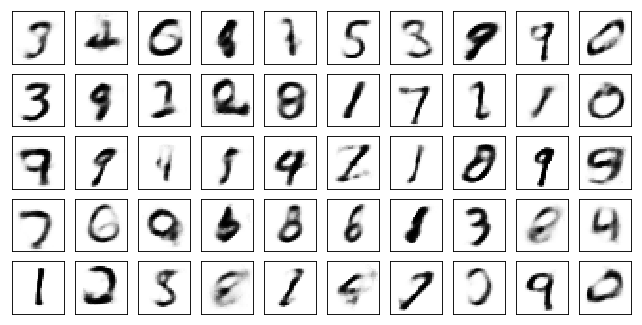

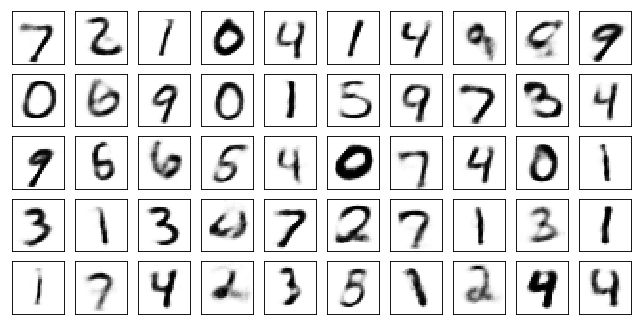

Test losses. E: 0.7032, AE: 0.0703, D: 0.6922
Train Epoch: 20 [0/50000 (0%)]	Losses E: 0.7068, AE: 0.0722, D: 0.6915
Train Epoch: 20 [5000/50000 (10%)]	Losses E: 0.6936, AE: 0.0680, D: 0.6951
Train Epoch: 20 [10000/50000 (20%)]	Losses E: 0.7007, AE: 0.0655, D: 0.6964
Train Epoch: 20 [15000/50000 (30%)]	Losses E: 0.7056, AE: 0.0639, D: 0.6941
Train Epoch: 20 [20000/50000 (40%)]	Losses E: 0.6949, AE: 0.0614, D: 0.6889
Train Epoch: 20 [25000/50000 (50%)]	Losses E: 0.6905, AE: 0.0703, D: 0.6944
Train Epoch: 20 [30000/50000 (60%)]	Losses E: 0.6881, AE: 0.0621, D: 0.6944
Train Epoch: 20 [35000/50000 (70%)]	Losses E: 0.6988, AE: 0.0778, D: 0.6923
Train Epoch: 20 [40000/50000 (80%)]	Losses E: 0.6938, AE: 0.0630, D: 0.6958
Train Epoch: 20 [45000/50000 (90%)]	Losses E: 0.6943, AE: 0.0692, D: 0.6924
Train Epoch: 20 [50000/50000 (100%)]	Losses E: 0.7123, AE: 0.0702, D: 0.6946


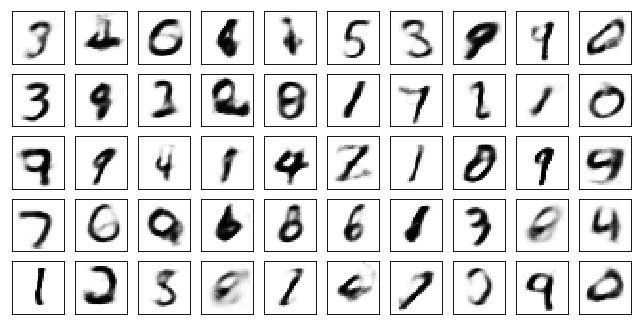

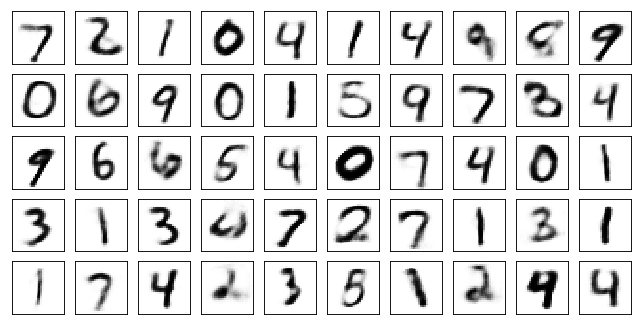

Test losses. E: 0.7106, AE: 0.0680, D: 0.6914
Train Epoch: 21 [0/50000 (0%)]	Losses E: 0.7056, AE: 0.0618, D: 0.6948
Train Epoch: 21 [5000/50000 (10%)]	Losses E: 0.6845, AE: 0.0691, D: 0.6956
Train Epoch: 21 [10000/50000 (20%)]	Losses E: 0.6904, AE: 0.0633, D: 0.6907
Train Epoch: 21 [15000/50000 (30%)]	Losses E: 0.6911, AE: 0.0713, D: 0.6928
Train Epoch: 21 [20000/50000 (40%)]	Losses E: 0.6910, AE: 0.0722, D: 0.6916
Train Epoch: 21 [25000/50000 (50%)]	Losses E: 0.7035, AE: 0.0691, D: 0.6920
Train Epoch: 21 [30000/50000 (60%)]	Losses E: 0.6967, AE: 0.0819, D: 0.6948
Train Epoch: 21 [35000/50000 (70%)]	Losses E: 0.6857, AE: 0.0605, D: 0.6946
Train Epoch: 21 [40000/50000 (80%)]	Losses E: 0.6866, AE: 0.0676, D: 0.6963
Train Epoch: 21 [45000/50000 (90%)]	Losses E: 0.6969, AE: 0.0587, D: 0.6927
Train Epoch: 21 [50000/50000 (100%)]	Losses E: 0.6864, AE: 0.0639, D: 0.6922


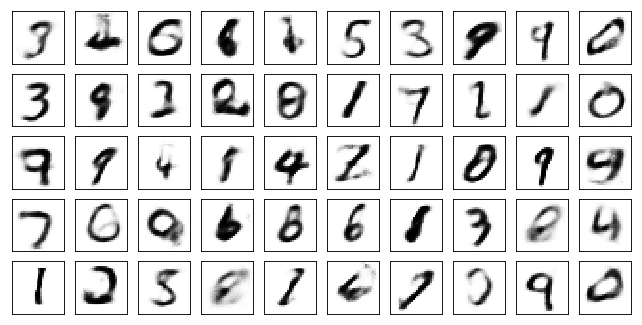

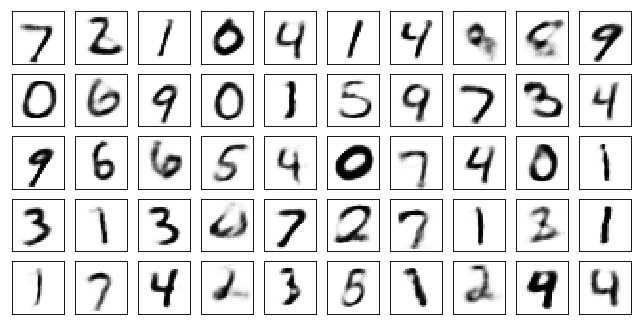

Test losses. E: 0.6863, AE: 0.0673, D: 0.6927
Train Epoch: 22 [0/50000 (0%)]	Losses E: 0.6922, AE: 0.0618, D: 0.6916
Train Epoch: 22 [5000/50000 (10%)]	Losses E: 0.6785, AE: 0.0740, D: 0.6972
Train Epoch: 22 [10000/50000 (20%)]	Losses E: 0.7048, AE: 0.0673, D: 0.6927
Train Epoch: 22 [15000/50000 (30%)]	Losses E: 0.6985, AE: 0.0719, D: 0.6902
Train Epoch: 22 [20000/50000 (40%)]	Losses E: 0.7000, AE: 0.0604, D: 0.6920
Train Epoch: 22 [25000/50000 (50%)]	Losses E: 0.6900, AE: 0.0647, D: 0.6892
Train Epoch: 22 [30000/50000 (60%)]	Losses E: 0.6876, AE: 0.0615, D: 0.6965
Train Epoch: 22 [35000/50000 (70%)]	Losses E: 0.7011, AE: 0.0577, D: 0.6939
Train Epoch: 22 [40000/50000 (80%)]	Losses E: 0.6907, AE: 0.0623, D: 0.6996
Train Epoch: 22 [45000/50000 (90%)]	Losses E: 0.6821, AE: 0.0709, D: 0.6958
Train Epoch: 22 [50000/50000 (100%)]	Losses E: 0.6906, AE: 0.0588, D: 0.6893


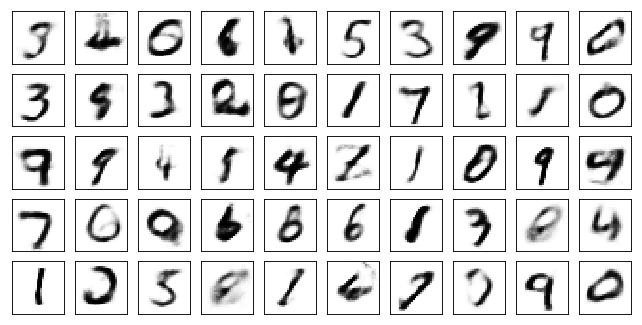

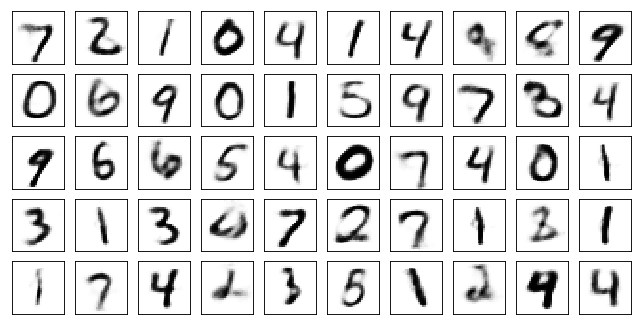

Test losses. E: 0.6914, AE: 0.0676, D: 0.6940
Train Epoch: 23 [0/50000 (0%)]	Losses E: 0.6896, AE: 0.0625, D: 0.6965
Train Epoch: 23 [5000/50000 (10%)]	Losses E: 0.7064, AE: 0.0635, D: 0.6913
Train Epoch: 23 [10000/50000 (20%)]	Losses E: 0.7091, AE: 0.0666, D: 0.6935
Train Epoch: 23 [15000/50000 (30%)]	Losses E: 0.6901, AE: 0.0691, D: 0.6991
Train Epoch: 23 [20000/50000 (40%)]	Losses E: 0.6980, AE: 0.0652, D: 0.6885
Train Epoch: 23 [25000/50000 (50%)]	Losses E: 0.6952, AE: 0.0698, D: 0.6958
Train Epoch: 23 [30000/50000 (60%)]	Losses E: 0.6898, AE: 0.0640, D: 0.6920
Train Epoch: 23 [35000/50000 (70%)]	Losses E: 0.6923, AE: 0.0628, D: 0.6988
Train Epoch: 23 [40000/50000 (80%)]	Losses E: 0.7065, AE: 0.0579, D: 0.6900
Train Epoch: 23 [45000/50000 (90%)]	Losses E: 0.7003, AE: 0.0697, D: 0.6904
Train Epoch: 23 [50000/50000 (100%)]	Losses E: 0.6857, AE: 0.0618, D: 0.6930


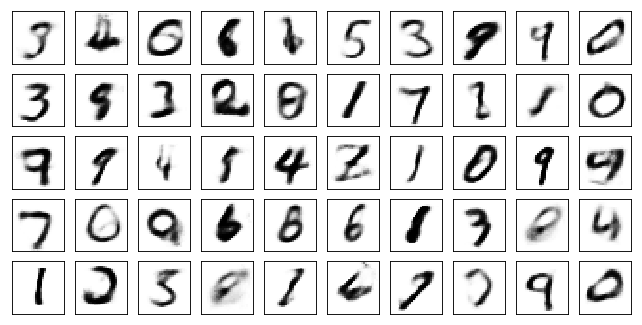

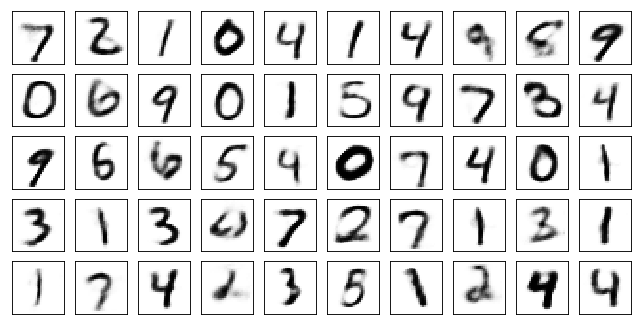

Test losses. E: 0.6855, AE: 0.0651, D: 0.6924
Train Epoch: 24 [0/50000 (0%)]	Losses E: 0.6894, AE: 0.0530, D: 0.6958
Train Epoch: 24 [5000/50000 (10%)]	Losses E: 0.6929, AE: 0.0650, D: 0.6920
Train Epoch: 24 [10000/50000 (20%)]	Losses E: 0.6985, AE: 0.0655, D: 0.6917
Train Epoch: 24 [15000/50000 (30%)]	Losses E: 0.6780, AE: 0.0652, D: 0.6952
Train Epoch: 24 [20000/50000 (40%)]	Losses E: 0.7055, AE: 0.0617, D: 0.6965
Train Epoch: 24 [25000/50000 (50%)]	Losses E: 0.6909, AE: 0.0685, D: 0.6953
Train Epoch: 24 [30000/50000 (60%)]	Losses E: 0.6960, AE: 0.0747, D: 0.6912
Train Epoch: 24 [35000/50000 (70%)]	Losses E: 0.7013, AE: 0.0682, D: 0.6894
Train Epoch: 24 [40000/50000 (80%)]	Losses E: 0.7084, AE: 0.0714, D: 0.6911
Train Epoch: 24 [45000/50000 (90%)]	Losses E: 0.6974, AE: 0.0631, D: 0.6912
Train Epoch: 24 [50000/50000 (100%)]	Losses E: 0.6962, AE: 0.0654, D: 0.6995


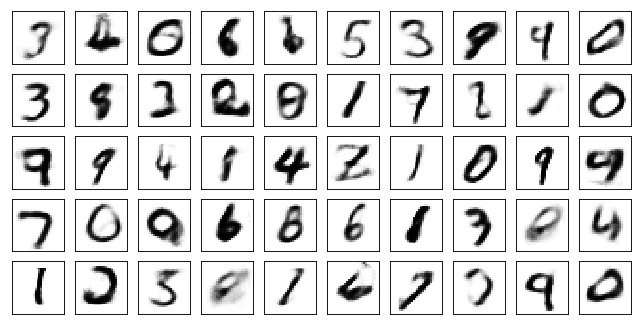

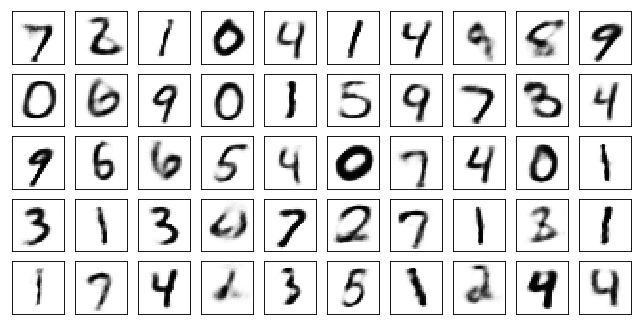

Test losses. E: 0.6887, AE: 0.0669, D: 0.6947
Train Epoch: 25 [0/50000 (0%)]	Losses E: 0.6887, AE: 0.0654, D: 0.6918
Train Epoch: 25 [5000/50000 (10%)]	Losses E: 0.6959, AE: 0.0635, D: 0.6902
Train Epoch: 25 [10000/50000 (20%)]	Losses E: 0.6863, AE: 0.0602, D: 0.6960
Train Epoch: 25 [15000/50000 (30%)]	Losses E: 0.6916, AE: 0.0591, D: 0.6910
Train Epoch: 25 [20000/50000 (40%)]	Losses E: 0.6932, AE: 0.0585, D: 0.6939
Train Epoch: 25 [25000/50000 (50%)]	Losses E: 0.6954, AE: 0.0636, D: 0.6933
Train Epoch: 25 [30000/50000 (60%)]	Losses E: 0.7064, AE: 0.0720, D: 0.6913
Train Epoch: 25 [35000/50000 (70%)]	Losses E: 0.6787, AE: 0.0677, D: 0.6939
Train Epoch: 25 [40000/50000 (80%)]	Losses E: 0.6902, AE: 0.0644, D: 0.6939
Train Epoch: 25 [45000/50000 (90%)]	Losses E: 0.7054, AE: 0.0544, D: 0.6924
Train Epoch: 25 [50000/50000 (100%)]	Losses E: 0.6958, AE: 0.0695, D: 0.6939


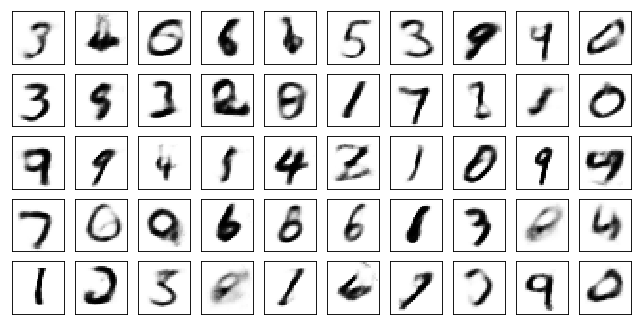

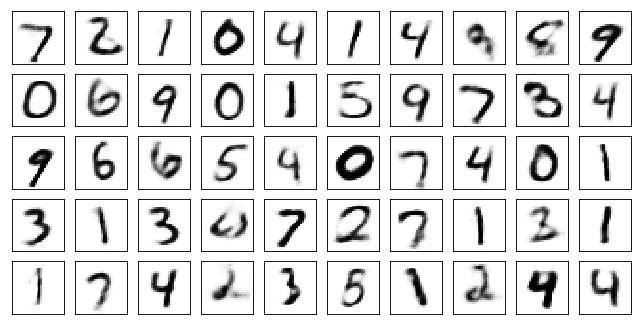

Test losses. E: 0.7005, AE: 0.0648, D: 0.6914
Train Epoch: 26 [0/50000 (0%)]	Losses E: 0.7019, AE: 0.0578, D: 0.6915
Train Epoch: 26 [5000/50000 (10%)]	Losses E: 0.6951, AE: 0.0527, D: 0.6921
Train Epoch: 26 [10000/50000 (20%)]	Losses E: 0.6947, AE: 0.0609, D: 0.6898
Train Epoch: 26 [15000/50000 (30%)]	Losses E: 0.7089, AE: 0.0579, D: 0.6937
Train Epoch: 26 [20000/50000 (40%)]	Losses E: 0.7044, AE: 0.0588, D: 0.6923
Train Epoch: 26 [25000/50000 (50%)]	Losses E: 0.6968, AE: 0.0556, D: 0.6950
Train Epoch: 26 [30000/50000 (60%)]	Losses E: 0.6929, AE: 0.0659, D: 0.6920
Train Epoch: 26 [35000/50000 (70%)]	Losses E: 0.6819, AE: 0.0651, D: 0.6894
Train Epoch: 26 [40000/50000 (80%)]	Losses E: 0.6888, AE: 0.0656, D: 0.6980
Train Epoch: 26 [45000/50000 (90%)]	Losses E: 0.7010, AE: 0.0747, D: 0.6977
Train Epoch: 26 [50000/50000 (100%)]	Losses E: 0.6950, AE: 0.0673, D: 0.6937


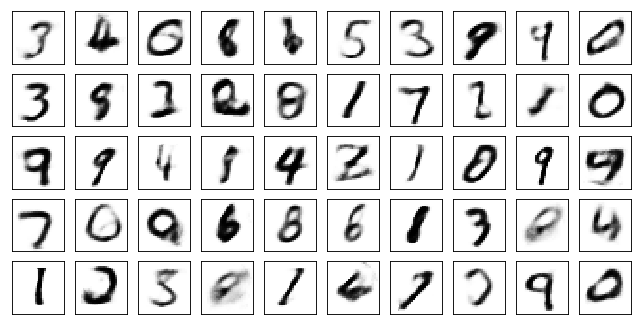

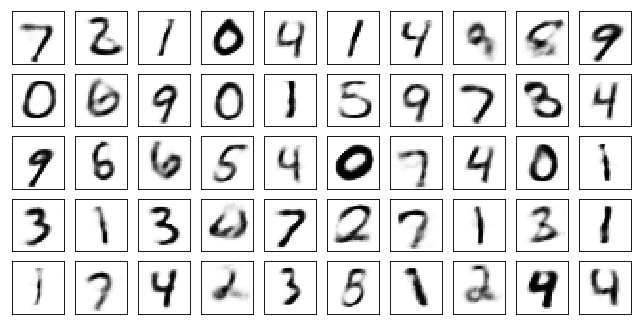

Test losses. E: 0.6987, AE: 0.0674, D: 0.6941
Train Epoch: 27 [0/50000 (0%)]	Losses E: 0.7037, AE: 0.0691, D: 0.6959
Train Epoch: 27 [5000/50000 (10%)]	Losses E: 0.6939, AE: 0.0579, D: 0.6942
Train Epoch: 27 [10000/50000 (20%)]	Losses E: 0.6861, AE: 0.0645, D: 0.6944
Train Epoch: 27 [15000/50000 (30%)]	Losses E: 0.6982, AE: 0.0641, D: 0.6934
Train Epoch: 27 [20000/50000 (40%)]	Losses E: 0.7050, AE: 0.0671, D: 0.6937
Train Epoch: 27 [25000/50000 (50%)]	Losses E: 0.6884, AE: 0.0656, D: 0.6941
Train Epoch: 27 [30000/50000 (60%)]	Losses E: 0.6884, AE: 0.0685, D: 0.6959
Train Epoch: 27 [35000/50000 (70%)]	Losses E: 0.7078, AE: 0.0597, D: 0.6963
Train Epoch: 27 [40000/50000 (80%)]	Losses E: 0.6877, AE: 0.0671, D: 0.7020
Train Epoch: 27 [45000/50000 (90%)]	Losses E: 0.6781, AE: 0.0694, D: 0.6880
Train Epoch: 27 [50000/50000 (100%)]	Losses E: 0.6903, AE: 0.0589, D: 0.6948


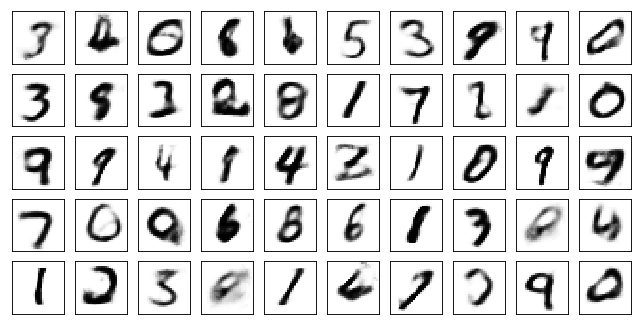

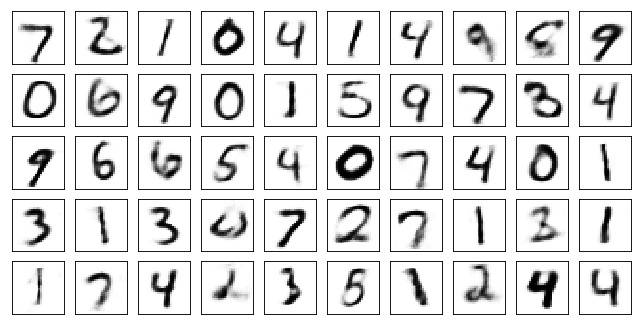

Test losses. E: 0.6904, AE: 0.0636, D: 0.6932
Train Epoch: 28 [0/50000 (0%)]	Losses E: 0.6890, AE: 0.0697, D: 0.6948
Train Epoch: 28 [5000/50000 (10%)]	Losses E: 0.7007, AE: 0.0588, D: 0.6933
Train Epoch: 28 [10000/50000 (20%)]	Losses E: 0.6729, AE: 0.0553, D: 0.6925
Train Epoch: 28 [15000/50000 (30%)]	Losses E: 0.6898, AE: 0.0676, D: 0.6894
Train Epoch: 28 [20000/50000 (40%)]	Losses E: 0.7011, AE: 0.0670, D: 0.6899
Train Epoch: 28 [25000/50000 (50%)]	Losses E: 0.6855, AE: 0.0674, D: 0.6954
Train Epoch: 28 [30000/50000 (60%)]	Losses E: 0.6909, AE: 0.0742, D: 0.6940
Train Epoch: 28 [35000/50000 (70%)]	Losses E: 0.7094, AE: 0.0575, D: 0.6960
Train Epoch: 28 [40000/50000 (80%)]	Losses E: 0.6800, AE: 0.0550, D: 0.6889
Train Epoch: 28 [45000/50000 (90%)]	Losses E: 0.6966, AE: 0.0634, D: 0.6966
Train Epoch: 28 [50000/50000 (100%)]	Losses E: 0.6935, AE: 0.0624, D: 0.6892


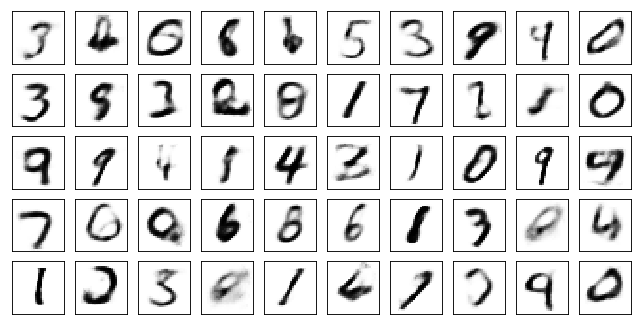

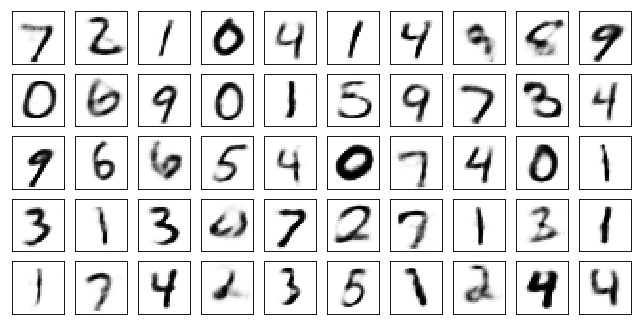

Test losses. E: 0.6980, AE: 0.0645, D: 0.6933
Train Epoch: 29 [0/50000 (0%)]	Losses E: 0.6973, AE: 0.0615, D: 0.6967
Train Epoch: 29 [5000/50000 (10%)]	Losses E: 0.6841, AE: 0.0695, D: 0.6957
Train Epoch: 29 [10000/50000 (20%)]	Losses E: 0.7036, AE: 0.0679, D: 0.6931
Train Epoch: 29 [15000/50000 (30%)]	Losses E: 0.7128, AE: 0.0673, D: 0.6946
Train Epoch: 29 [20000/50000 (40%)]	Losses E: 0.6836, AE: 0.0628, D: 0.6929
Train Epoch: 29 [25000/50000 (50%)]	Losses E: 0.6913, AE: 0.0629, D: 0.6887
Train Epoch: 29 [30000/50000 (60%)]	Losses E: 0.6957, AE: 0.0555, D: 0.6912
Train Epoch: 29 [35000/50000 (70%)]	Losses E: 0.6892, AE: 0.0701, D: 0.6942
Train Epoch: 29 [40000/50000 (80%)]	Losses E: 0.6994, AE: 0.0592, D: 0.6929
Train Epoch: 29 [45000/50000 (90%)]	Losses E: 0.6863, AE: 0.0654, D: 0.6970
Train Epoch: 29 [50000/50000 (100%)]	Losses E: 0.6880, AE: 0.0546, D: 0.6944


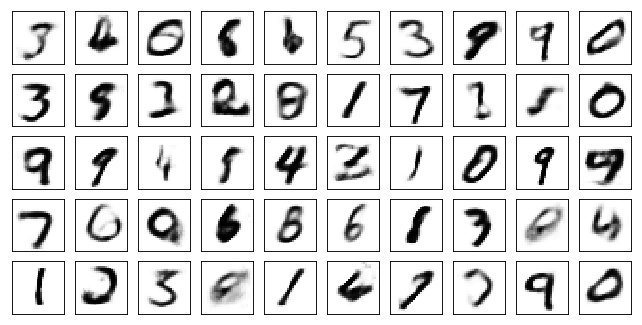

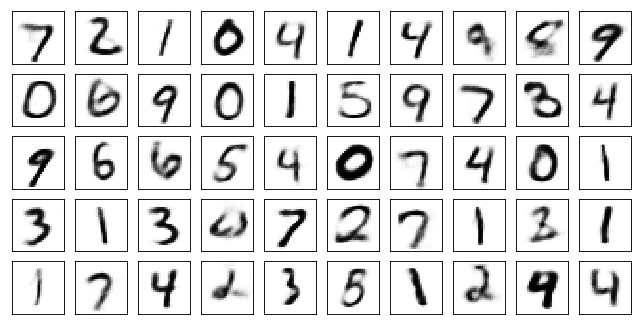

Test losses. E: 0.6911, AE: 0.0615, D: 0.6910
Train Epoch: 30 [0/50000 (0%)]	Losses E: 0.6942, AE: 0.0611, D: 0.6892
Train Epoch: 30 [5000/50000 (10%)]	Losses E: 0.7118, AE: 0.0595, D: 0.6933
Train Epoch: 30 [10000/50000 (20%)]	Losses E: 0.7022, AE: 0.0624, D: 0.6935
Train Epoch: 30 [15000/50000 (30%)]	Losses E: 0.7048, AE: 0.0655, D: 0.6947
Train Epoch: 30 [20000/50000 (40%)]	Losses E: 0.6951, AE: 0.0608, D: 0.6902
Train Epoch: 30 [25000/50000 (50%)]	Losses E: 0.6737, AE: 0.0509, D: 0.6962
Train Epoch: 30 [30000/50000 (60%)]	Losses E: 0.6967, AE: 0.0556, D: 0.6935
Train Epoch: 30 [35000/50000 (70%)]	Losses E: 0.6874, AE: 0.0640, D: 0.6926
Train Epoch: 30 [40000/50000 (80%)]	Losses E: 0.7030, AE: 0.0684, D: 0.6911
Train Epoch: 30 [45000/50000 (90%)]	Losses E: 0.7109, AE: 0.0551, D: 0.6909
Train Epoch: 30 [50000/50000 (100%)]	Losses E: 0.7031, AE: 0.0603, D: 0.6948


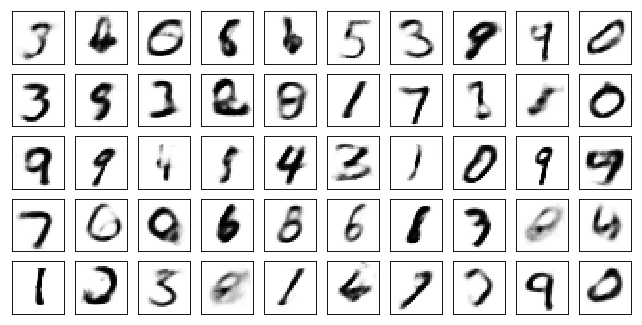

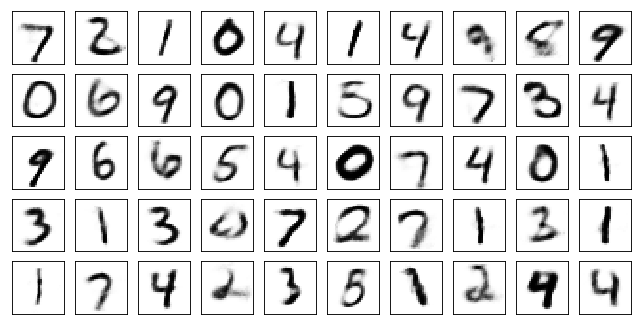

Test losses. E: 0.6996, AE: 0.0638, D: 0.6929
Train Epoch: 31 [0/50000 (0%)]	Losses E: 0.7065, AE: 0.0612, D: 0.6918
Train Epoch: 31 [5000/50000 (10%)]	Losses E: 0.6881, AE: 0.0656, D: 0.6941
Train Epoch: 31 [10000/50000 (20%)]	Losses E: 0.6912, AE: 0.0585, D: 0.6851
Train Epoch: 31 [15000/50000 (30%)]	Losses E: 0.6995, AE: 0.0561, D: 0.6982
Train Epoch: 31 [20000/50000 (40%)]	Losses E: 0.6892, AE: 0.0570, D: 0.6906
Train Epoch: 31 [25000/50000 (50%)]	Losses E: 0.6888, AE: 0.0638, D: 0.6944
Train Epoch: 31 [30000/50000 (60%)]	Losses E: 0.6991, AE: 0.0650, D: 0.6927
Train Epoch: 31 [35000/50000 (70%)]	Losses E: 0.6847, AE: 0.0551, D: 0.6935
Train Epoch: 31 [40000/50000 (80%)]	Losses E: 0.6887, AE: 0.0592, D: 0.6912
Train Epoch: 31 [45000/50000 (90%)]	Losses E: 0.6913, AE: 0.0592, D: 0.6925
Train Epoch: 31 [50000/50000 (100%)]	Losses E: 0.7060, AE: 0.0633, D: 0.6921


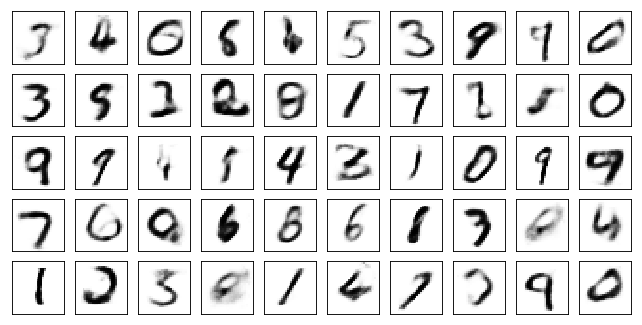

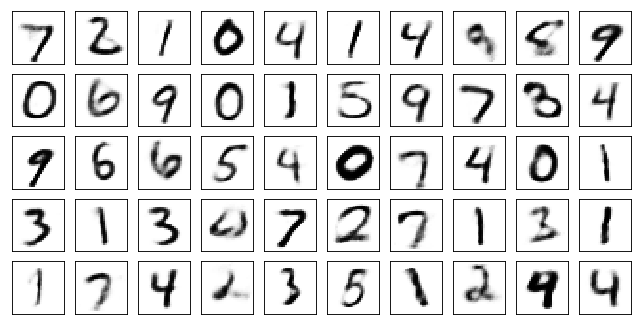

Test losses. E: 0.6990, AE: 0.0614, D: 0.6912
Train Epoch: 32 [0/50000 (0%)]	Losses E: 0.7033, AE: 0.0609, D: 0.6941
Train Epoch: 32 [5000/50000 (10%)]	Losses E: 0.6840, AE: 0.0520, D: 0.6929
Train Epoch: 32 [10000/50000 (20%)]	Losses E: 0.6863, AE: 0.0705, D: 0.6935
Train Epoch: 32 [15000/50000 (30%)]	Losses E: 0.6972, AE: 0.0558, D: 0.6953
Train Epoch: 32 [20000/50000 (40%)]	Losses E: 0.6882, AE: 0.0626, D: 0.6942
Train Epoch: 32 [25000/50000 (50%)]	Losses E: 0.7003, AE: 0.0586, D: 0.6903
Train Epoch: 32 [30000/50000 (60%)]	Losses E: 0.6945, AE: 0.0557, D: 0.6919
Train Epoch: 32 [35000/50000 (70%)]	Losses E: 0.7047, AE: 0.0656, D: 0.6927
Train Epoch: 32 [40000/50000 (80%)]	Losses E: 0.7022, AE: 0.0629, D: 0.6916
Train Epoch: 32 [45000/50000 (90%)]	Losses E: 0.6920, AE: 0.0577, D: 0.6921
Train Epoch: 32 [50000/50000 (100%)]	Losses E: 0.6883, AE: 0.0559, D: 0.6954


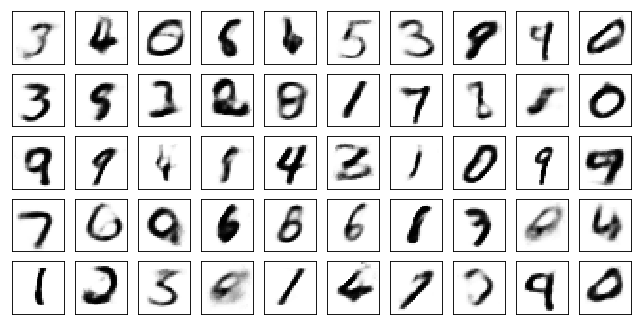

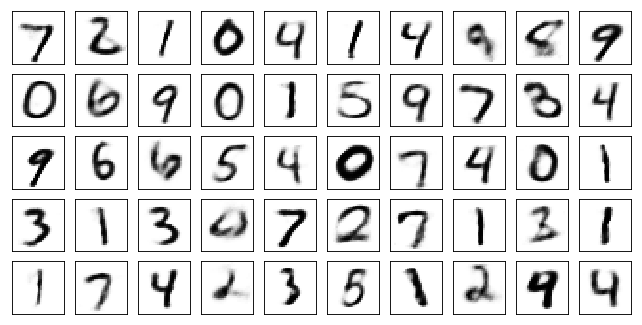

Test losses. E: 0.6867, AE: 0.0627, D: 0.6941
Train Epoch: 33 [0/50000 (0%)]	Losses E: 0.6837, AE: 0.0616, D: 0.6983
Train Epoch: 33 [5000/50000 (10%)]	Losses E: 0.6920, AE: 0.0619, D: 0.6909
Train Epoch: 33 [10000/50000 (20%)]	Losses E: 0.6880, AE: 0.0615, D: 0.6895
Train Epoch: 33 [15000/50000 (30%)]	Losses E: 0.6842, AE: 0.0504, D: 0.6974
Train Epoch: 33 [20000/50000 (40%)]	Losses E: 0.6967, AE: 0.0564, D: 0.6939
Train Epoch: 33 [25000/50000 (50%)]	Losses E: 0.6976, AE: 0.0619, D: 0.6916
Train Epoch: 33 [30000/50000 (60%)]	Losses E: 0.6882, AE: 0.0796, D: 0.6962
Train Epoch: 33 [35000/50000 (70%)]	Losses E: 0.6938, AE: 0.0539, D: 0.6928
Train Epoch: 33 [40000/50000 (80%)]	Losses E: 0.7003, AE: 0.0586, D: 0.6932
Train Epoch: 33 [45000/50000 (90%)]	Losses E: 0.6910, AE: 0.0567, D: 0.6947
Train Epoch: 33 [50000/50000 (100%)]	Losses E: 0.6989, AE: 0.0666, D: 0.6936


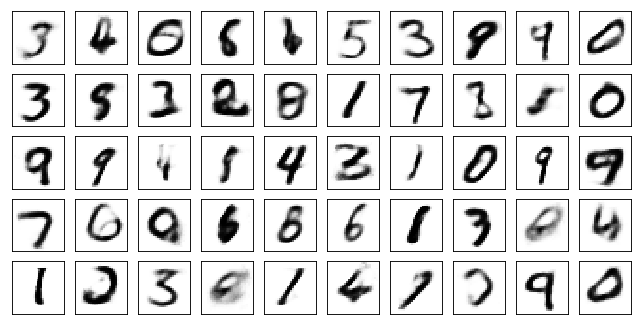

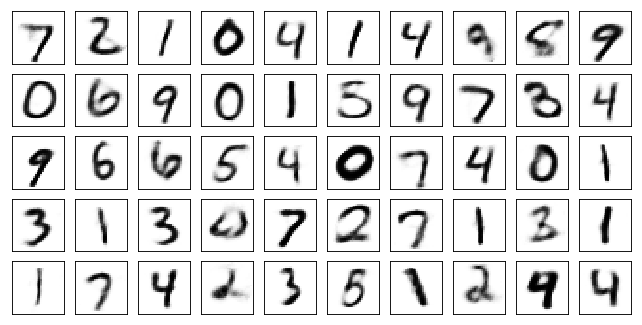

Test losses. E: 0.6982, AE: 0.0609, D: 0.6920
Train Epoch: 34 [0/50000 (0%)]	Losses E: 0.7031, AE: 0.0565, D: 0.6871
Train Epoch: 34 [5000/50000 (10%)]	Losses E: 0.6991, AE: 0.0587, D: 0.6938
Train Epoch: 34 [10000/50000 (20%)]	Losses E: 0.6907, AE: 0.0643, D: 0.6908
Train Epoch: 34 [15000/50000 (30%)]	Losses E: 0.7020, AE: 0.0684, D: 0.6927
Train Epoch: 34 [20000/50000 (40%)]	Losses E: 0.7060, AE: 0.0549, D: 0.6940
Train Epoch: 34 [25000/50000 (50%)]	Losses E: 0.6972, AE: 0.0580, D: 0.6929
Train Epoch: 34 [30000/50000 (60%)]	Losses E: 0.6897, AE: 0.0605, D: 0.6899
Train Epoch: 34 [35000/50000 (70%)]	Losses E: 0.6978, AE: 0.0616, D: 0.6957
Train Epoch: 34 [40000/50000 (80%)]	Losses E: 0.6932, AE: 0.0548, D: 0.6932
Train Epoch: 34 [45000/50000 (90%)]	Losses E: 0.6896, AE: 0.0614, D: 0.6941
Train Epoch: 34 [50000/50000 (100%)]	Losses E: 0.6931, AE: 0.0505, D: 0.6924


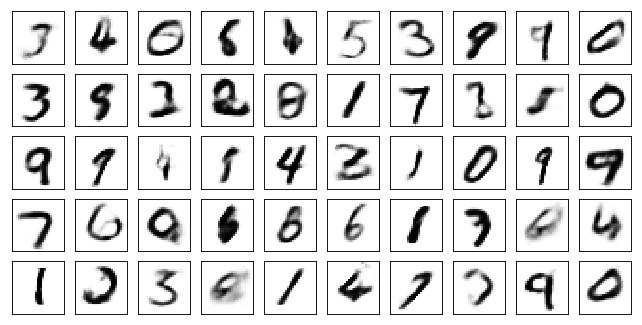

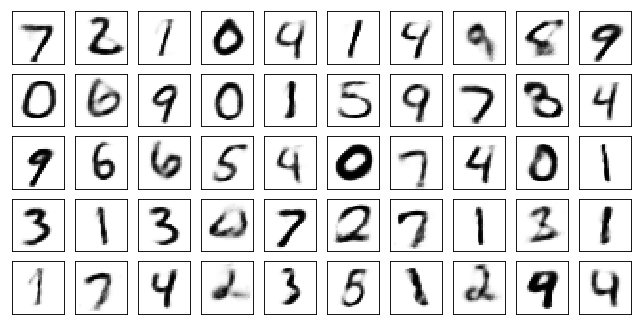

Test losses. E: 0.6882, AE: 0.0622, D: 0.6943
Train Epoch: 35 [0/50000 (0%)]	Losses E: 0.6947, AE: 0.0628, D: 0.6928
Train Epoch: 35 [5000/50000 (10%)]	Losses E: 0.7000, AE: 0.0581, D: 0.6901
Train Epoch: 35 [10000/50000 (20%)]	Losses E: 0.6926, AE: 0.0673, D: 0.6970
Train Epoch: 35 [15000/50000 (30%)]	Losses E: 0.6919, AE: 0.0610, D: 0.6947
Train Epoch: 35 [20000/50000 (40%)]	Losses E: 0.6874, AE: 0.0579, D: 0.6983
Train Epoch: 35 [25000/50000 (50%)]	Losses E: 0.6909, AE: 0.0519, D: 0.6953
Train Epoch: 35 [30000/50000 (60%)]	Losses E: 0.6907, AE: 0.0536, D: 0.6885
Train Epoch: 35 [35000/50000 (70%)]	Losses E: 0.7105, AE: 0.0587, D: 0.6890
Train Epoch: 35 [40000/50000 (80%)]	Losses E: 0.7223, AE: 0.0542, D: 0.6913
Train Epoch: 35 [45000/50000 (90%)]	Losses E: 0.6880, AE: 0.0601, D: 0.6884
Train Epoch: 35 [50000/50000 (100%)]	Losses E: 0.6967, AE: 0.0546, D: 0.6923


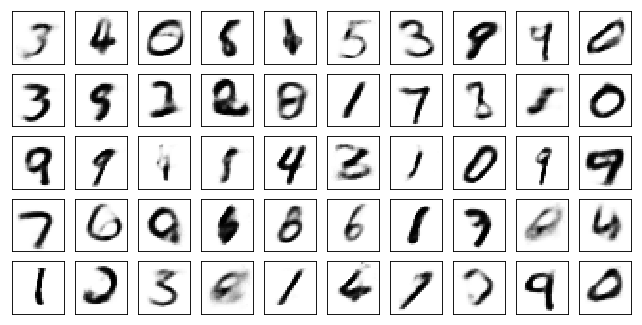

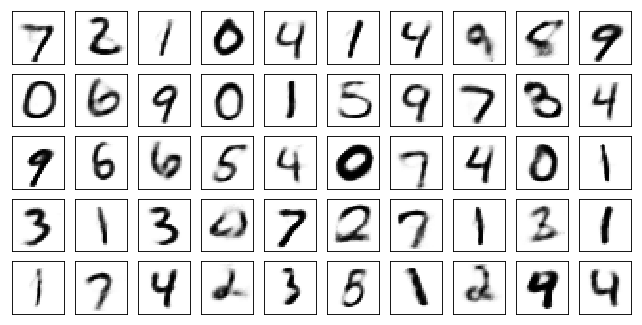

Test losses. E: 0.6968, AE: 0.0597, D: 0.6915
Train Epoch: 36 [0/50000 (0%)]	Losses E: 0.7009, AE: 0.0534, D: 0.6899
Train Epoch: 36 [5000/50000 (10%)]	Losses E: 0.7015, AE: 0.0632, D: 0.6905
Train Epoch: 36 [10000/50000 (20%)]	Losses E: 0.6985, AE: 0.0590, D: 0.6908
Train Epoch: 36 [15000/50000 (30%)]	Losses E: 0.6821, AE: 0.0461, D: 0.6987
Train Epoch: 36 [20000/50000 (40%)]	Losses E: 0.6978, AE: 0.0482, D: 0.6944
Train Epoch: 36 [25000/50000 (50%)]	Losses E: 0.7028, AE: 0.0502, D: 0.6911
Train Epoch: 36 [30000/50000 (60%)]	Losses E: 0.6860, AE: 0.0614, D: 0.6961
Train Epoch: 36 [35000/50000 (70%)]	Losses E: 0.6799, AE: 0.0596, D: 0.6945
Train Epoch: 36 [40000/50000 (80%)]	Losses E: 0.6914, AE: 0.0460, D: 0.6977
Train Epoch: 36 [45000/50000 (90%)]	Losses E: 0.7061, AE: 0.0536, D: 0.6954
Train Epoch: 36 [50000/50000 (100%)]	Losses E: 0.6867, AE: 0.0599, D: 0.6980


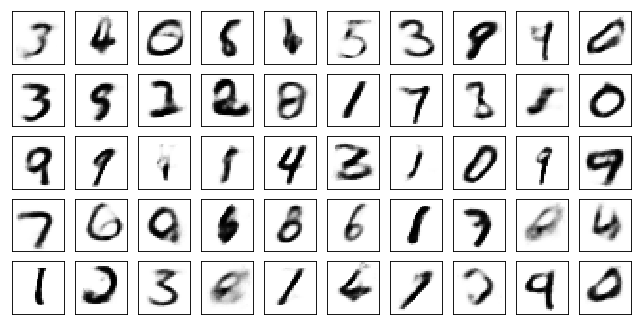

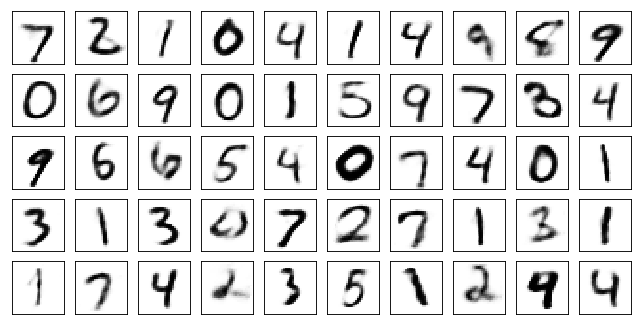

Test losses. E: 0.6887, AE: 0.0612, D: 0.6936
Train Epoch: 37 [0/50000 (0%)]	Losses E: 0.6858, AE: 0.0561, D: 0.6921
Train Epoch: 37 [5000/50000 (10%)]	Losses E: 0.6963, AE: 0.0575, D: 0.6889
Train Epoch: 37 [10000/50000 (20%)]	Losses E: 0.6993, AE: 0.0631, D: 0.6923
Train Epoch: 37 [15000/50000 (30%)]	Losses E: 0.6984, AE: 0.0653, D: 0.6920
Train Epoch: 37 [20000/50000 (40%)]	Losses E: 0.6967, AE: 0.0618, D: 0.6934
Train Epoch: 37 [25000/50000 (50%)]	Losses E: 0.6959, AE: 0.0565, D: 0.6923
Train Epoch: 37 [30000/50000 (60%)]	Losses E: 0.6948, AE: 0.0611, D: 0.6947
Train Epoch: 37 [35000/50000 (70%)]	Losses E: 0.6804, AE: 0.0632, D: 0.6915
Train Epoch: 37 [40000/50000 (80%)]	Losses E: 0.6780, AE: 0.0571, D: 0.6926
Train Epoch: 37 [45000/50000 (90%)]	Losses E: 0.6974, AE: 0.0627, D: 0.6987
Train Epoch: 37 [50000/50000 (100%)]	Losses E: 0.7135, AE: 0.0547, D: 0.6976


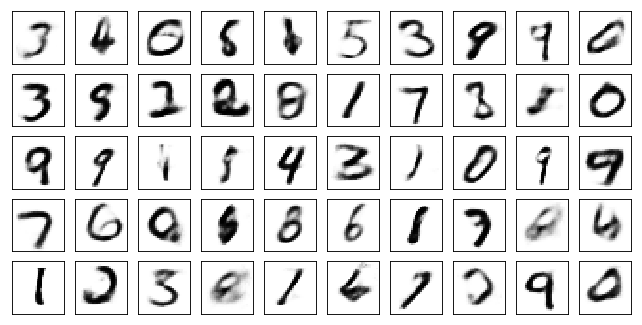

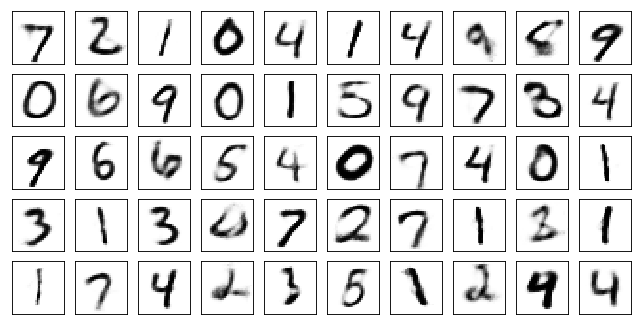

Test losses. E: 0.7043, AE: 0.0623, D: 0.6944
Train Epoch: 38 [0/50000 (0%)]	Losses E: 0.7042, AE: 0.0539, D: 0.6934
Train Epoch: 38 [5000/50000 (10%)]	Losses E: 0.6836, AE: 0.0662, D: 0.6902
Train Epoch: 38 [10000/50000 (20%)]	Losses E: 0.7149, AE: 0.0559, D: 0.6944
Train Epoch: 38 [15000/50000 (30%)]	Losses E: 0.7068, AE: 0.0574, D: 0.6941
Train Epoch: 38 [20000/50000 (40%)]	Losses E: 0.7000, AE: 0.0509, D: 0.6956
Train Epoch: 38 [25000/50000 (50%)]	Losses E: 0.6929, AE: 0.0631, D: 0.6922
Train Epoch: 38 [30000/50000 (60%)]	Losses E: 0.7017, AE: 0.0506, D: 0.6907
Train Epoch: 38 [35000/50000 (70%)]	Losses E: 0.7040, AE: 0.0550, D: 0.6926
Train Epoch: 38 [40000/50000 (80%)]	Losses E: 0.6933, AE: 0.0645, D: 0.6902
Train Epoch: 38 [45000/50000 (90%)]	Losses E: 0.7012, AE: 0.0662, D: 0.6946
Train Epoch: 38 [50000/50000 (100%)]	Losses E: 0.6953, AE: 0.0562, D: 0.6953


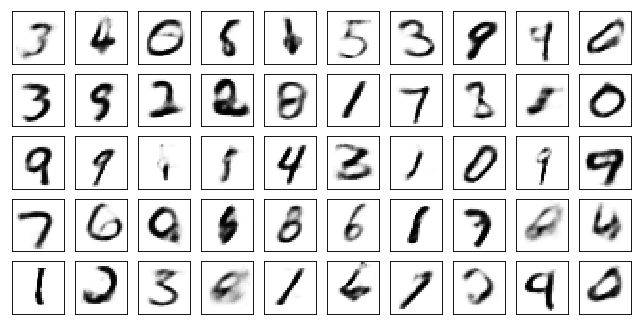

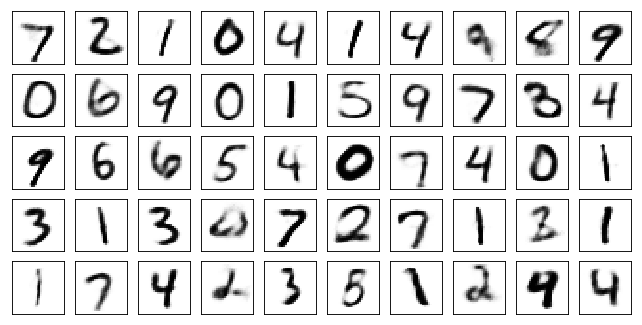

Test losses. E: 0.6894, AE: 0.0597, D: 0.6932
Train Epoch: 39 [0/50000 (0%)]	Losses E: 0.6876, AE: 0.0545, D: 0.6969
Train Epoch: 39 [5000/50000 (10%)]	Losses E: 0.6935, AE: 0.0576, D: 0.6900
Train Epoch: 39 [10000/50000 (20%)]	Losses E: 0.6958, AE: 0.0583, D: 0.6955
Train Epoch: 39 [15000/50000 (30%)]	Losses E: 0.6970, AE: 0.0599, D: 0.6931
Train Epoch: 39 [20000/50000 (40%)]	Losses E: 0.6855, AE: 0.0559, D: 0.6928
Train Epoch: 39 [25000/50000 (50%)]	Losses E: 0.6966, AE: 0.0512, D: 0.6938
Train Epoch: 39 [30000/50000 (60%)]	Losses E: 0.7081, AE: 0.0571, D: 0.6913
Train Epoch: 39 [35000/50000 (70%)]	Losses E: 0.6943, AE: 0.0623, D: 0.6900
Train Epoch: 39 [40000/50000 (80%)]	Losses E: 0.6938, AE: 0.0421, D: 0.6929
Train Epoch: 39 [45000/50000 (90%)]	Losses E: 0.7017, AE: 0.0742, D: 0.6948
Train Epoch: 39 [50000/50000 (100%)]	Losses E: 0.6938, AE: 0.0579, D: 0.6926


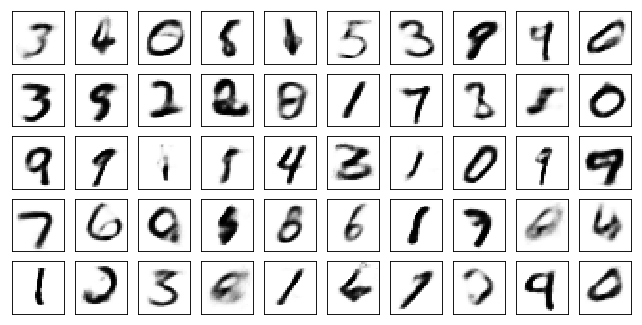

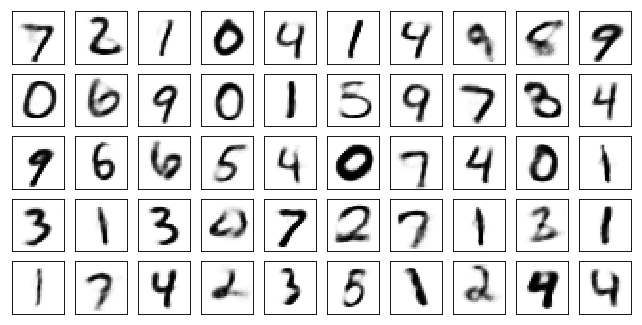

Test losses. E: 0.6898, AE: 0.0596, D: 0.6924
Train Epoch: 40 [0/50000 (0%)]	Losses E: 0.6942, AE: 0.0583, D: 0.6957
Train Epoch: 40 [5000/50000 (10%)]	Losses E: 0.6977, AE: 0.0561, D: 0.6942
Train Epoch: 40 [10000/50000 (20%)]	Losses E: 0.7146, AE: 0.0545, D: 0.6949
Train Epoch: 40 [15000/50000 (30%)]	Losses E: 0.6912, AE: 0.0562, D: 0.6912
Train Epoch: 40 [20000/50000 (40%)]	Losses E: 0.7089, AE: 0.0635, D: 0.6966
Train Epoch: 40 [25000/50000 (50%)]	Losses E: 0.6973, AE: 0.0603, D: 0.6875
Train Epoch: 40 [30000/50000 (60%)]	Losses E: 0.6858, AE: 0.0478, D: 0.6939
Train Epoch: 40 [35000/50000 (70%)]	Losses E: 0.6952, AE: 0.0544, D: 0.6974
Train Epoch: 40 [40000/50000 (80%)]	Losses E: 0.6999, AE: 0.0609, D: 0.6932
Train Epoch: 40 [45000/50000 (90%)]	Losses E: 0.6994, AE: 0.0566, D: 0.6944
Train Epoch: 40 [50000/50000 (100%)]	Losses E: 0.7000, AE: 0.0587, D: 0.6944


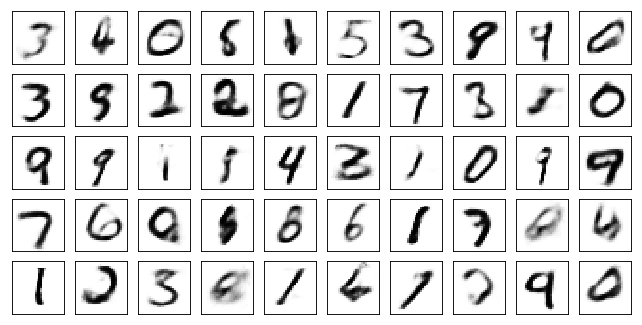

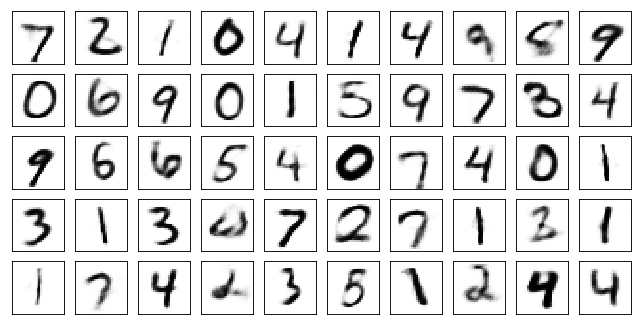

Test losses. E: 0.6986, AE: 0.0592, D: 0.6925
Train Epoch: 41 [0/50000 (0%)]	Losses E: 0.6972, AE: 0.0603, D: 0.6904
Train Epoch: 41 [5000/50000 (10%)]	Losses E: 0.6971, AE: 0.0521, D: 0.6957
Train Epoch: 41 [10000/50000 (20%)]	Losses E: 0.7034, AE: 0.0630, D: 0.6914
Train Epoch: 41 [15000/50000 (30%)]	Losses E: 0.7096, AE: 0.0690, D: 0.6965
Train Epoch: 41 [20000/50000 (40%)]	Losses E: 0.6828, AE: 0.0603, D: 0.6982
Train Epoch: 41 [25000/50000 (50%)]	Losses E: 0.7007, AE: 0.0556, D: 0.6876
Train Epoch: 41 [30000/50000 (60%)]	Losses E: 0.7138, AE: 0.0599, D: 0.6928
Train Epoch: 41 [35000/50000 (70%)]	Losses E: 0.6862, AE: 0.0649, D: 0.6936
Train Epoch: 41 [40000/50000 (80%)]	Losses E: 0.6987, AE: 0.0605, D: 0.6912
Train Epoch: 41 [45000/50000 (90%)]	Losses E: 0.6962, AE: 0.0559, D: 0.6893
Train Epoch: 41 [50000/50000 (100%)]	Losses E: 0.6801, AE: 0.0542, D: 0.6905


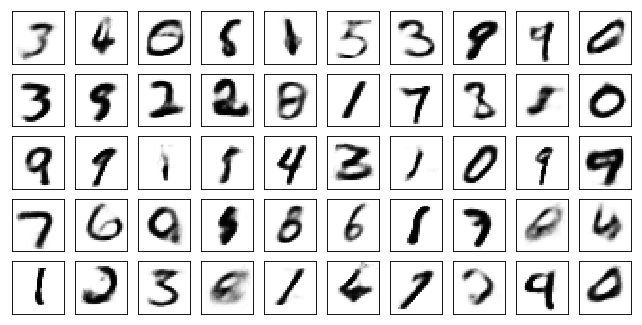

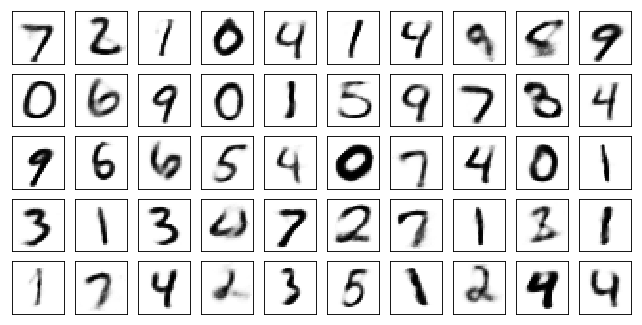

Test losses. E: 0.6802, AE: 0.0588, D: 0.6920
Train Epoch: 42 [0/50000 (0%)]	Losses E: 0.6820, AE: 0.0525, D: 0.6909
Train Epoch: 42 [5000/50000 (10%)]	Losses E: 0.6932, AE: 0.0543, D: 0.6950
Train Epoch: 42 [10000/50000 (20%)]	Losses E: 0.6935, AE: 0.0475, D: 0.6931
Train Epoch: 42 [15000/50000 (30%)]	Losses E: 0.6949, AE: 0.0517, D: 0.6915
Train Epoch: 42 [20000/50000 (40%)]	Losses E: 0.7030, AE: 0.0663, D: 0.6909
Train Epoch: 42 [25000/50000 (50%)]	Losses E: 0.6770, AE: 0.0622, D: 0.6945
Train Epoch: 42 [30000/50000 (60%)]	Losses E: 0.6900, AE: 0.0506, D: 0.6952
Train Epoch: 42 [35000/50000 (70%)]	Losses E: 0.6916, AE: 0.0542, D: 0.6905
Train Epoch: 42 [40000/50000 (80%)]	Losses E: 0.6870, AE: 0.0497, D: 0.6908
Train Epoch: 42 [45000/50000 (90%)]	Losses E: 0.7159, AE: 0.0649, D: 0.6920
Train Epoch: 42 [50000/50000 (100%)]	Losses E: 0.7126, AE: 0.0541, D: 0.6954


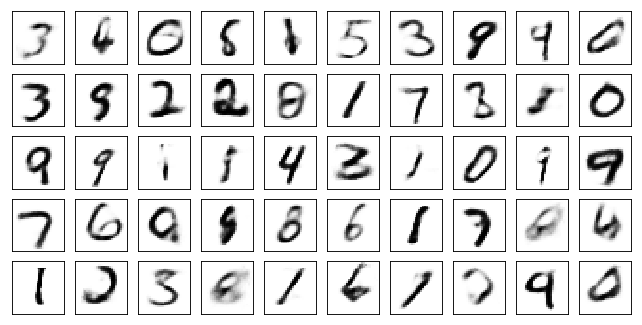

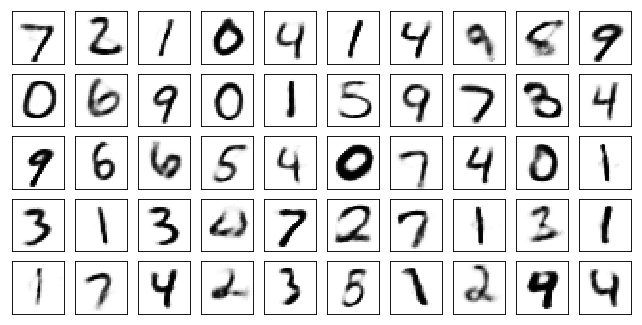

Test losses. E: 0.7111, AE: 0.0590, D: 0.6917
Train Epoch: 43 [0/50000 (0%)]	Losses E: 0.7098, AE: 0.0577, D: 0.6968
Train Epoch: 43 [5000/50000 (10%)]	Losses E: 0.7026, AE: 0.0665, D: 0.6885
Train Epoch: 43 [10000/50000 (20%)]	Losses E: 0.7074, AE: 0.0529, D: 0.6931
Train Epoch: 43 [15000/50000 (30%)]	Losses E: 0.6834, AE: 0.0519, D: 0.6979
Train Epoch: 43 [20000/50000 (40%)]	Losses E: 0.7000, AE: 0.0519, D: 0.6935
Train Epoch: 43 [25000/50000 (50%)]	Losses E: 0.7016, AE: 0.0547, D: 0.6904
Train Epoch: 43 [30000/50000 (60%)]	Losses E: 0.6885, AE: 0.0610, D: 0.6906
Train Epoch: 43 [35000/50000 (70%)]	Losses E: 0.6988, AE: 0.0660, D: 0.6921
Train Epoch: 43 [40000/50000 (80%)]	Losses E: 0.6940, AE: 0.0534, D: 0.6978
Train Epoch: 43 [45000/50000 (90%)]	Losses E: 0.6789, AE: 0.0610, D: 0.6937
Train Epoch: 43 [50000/50000 (100%)]	Losses E: 0.7035, AE: 0.0586, D: 0.6919


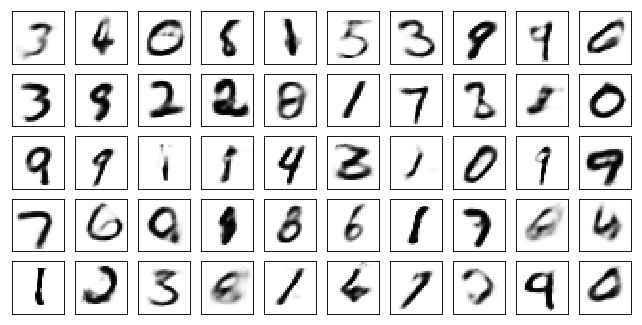

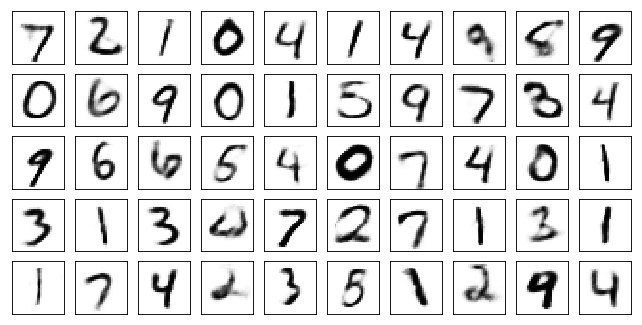

Test losses. E: 0.6944, AE: 0.0590, D: 0.6935
Train Epoch: 44 [0/50000 (0%)]	Losses E: 0.6959, AE: 0.0608, D: 0.6966
Train Epoch: 44 [5000/50000 (10%)]	Losses E: 0.6874, AE: 0.0536, D: 0.6872
Train Epoch: 44 [10000/50000 (20%)]	Losses E: 0.6969, AE: 0.0465, D: 0.6939
Train Epoch: 44 [15000/50000 (30%)]	Losses E: 0.7033, AE: 0.0524, D: 0.6836
Train Epoch: 44 [20000/50000 (40%)]	Losses E: 0.6883, AE: 0.0607, D: 0.6894
Train Epoch: 44 [25000/50000 (50%)]	Losses E: 0.6967, AE: 0.0439, D: 0.6939
Train Epoch: 44 [30000/50000 (60%)]	Losses E: 0.7023, AE: 0.0565, D: 0.6957
Train Epoch: 44 [35000/50000 (70%)]	Losses E: 0.6960, AE: 0.0635, D: 0.6922
Train Epoch: 44 [40000/50000 (80%)]	Losses E: 0.6936, AE: 0.0506, D: 0.6946
Train Epoch: 44 [45000/50000 (90%)]	Losses E: 0.6890, AE: 0.0487, D: 0.6926
Train Epoch: 44 [50000/50000 (100%)]	Losses E: 0.6617, AE: 0.0518, D: 0.6959


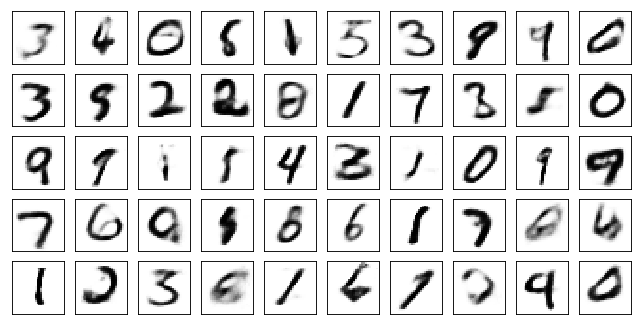

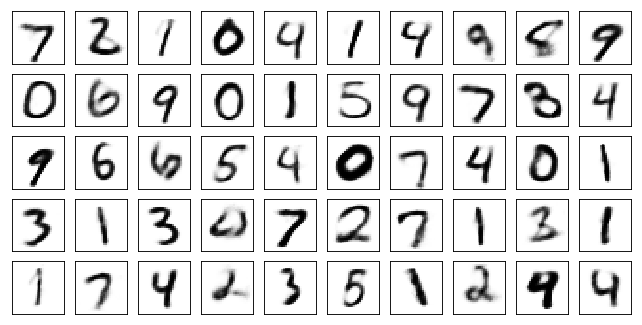

Test losses. E: 0.6693, AE: 0.0581, D: 0.6932
Train Epoch: 45 [0/50000 (0%)]	Losses E: 0.6818, AE: 0.0476, D: 0.6923
Train Epoch: 45 [5000/50000 (10%)]	Losses E: 0.6958, AE: 0.0569, D: 0.6953
Train Epoch: 45 [10000/50000 (20%)]	Losses E: 0.7031, AE: 0.0538, D: 0.6955
Train Epoch: 45 [15000/50000 (30%)]	Losses E: 0.6878, AE: 0.0564, D: 0.6928
Train Epoch: 45 [20000/50000 (40%)]	Losses E: 0.7069, AE: 0.0545, D: 0.6934
Train Epoch: 45 [25000/50000 (50%)]	Losses E: 0.7043, AE: 0.0559, D: 0.6956
Train Epoch: 45 [30000/50000 (60%)]	Losses E: 0.6961, AE: 0.0547, D: 0.6944
Train Epoch: 45 [35000/50000 (70%)]	Losses E: 0.6986, AE: 0.0571, D: 0.6960
Train Epoch: 45 [40000/50000 (80%)]	Losses E: 0.6914, AE: 0.0549, D: 0.6971
Train Epoch: 45 [45000/50000 (90%)]	Losses E: 0.7001, AE: 0.0490, D: 0.6918
Train Epoch: 45 [50000/50000 (100%)]	Losses E: 0.6845, AE: 0.0497, D: 0.6931


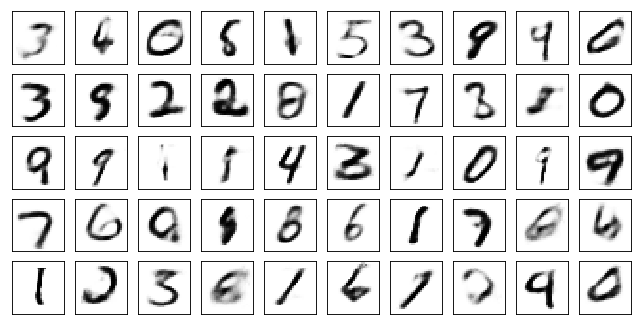

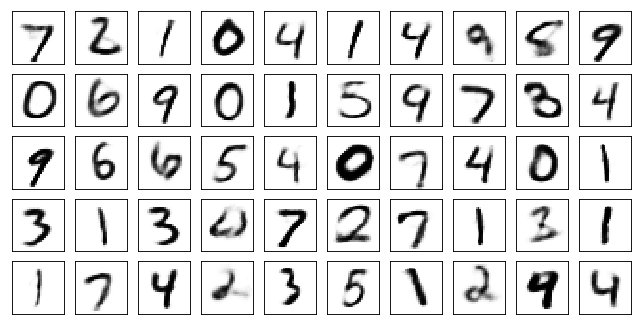

Test losses. E: 0.6875, AE: 0.0582, D: 0.6935
Train Epoch: 46 [0/50000 (0%)]	Losses E: 0.6907, AE: 0.0603, D: 0.6916
Train Epoch: 46 [5000/50000 (10%)]	Losses E: 0.6967, AE: 0.0622, D: 0.6906
Train Epoch: 46 [10000/50000 (20%)]	Losses E: 0.7072, AE: 0.0514, D: 0.6876
Train Epoch: 46 [15000/50000 (30%)]	Losses E: 0.6817, AE: 0.0594, D: 0.6949
Train Epoch: 46 [20000/50000 (40%)]	Losses E: 0.6944, AE: 0.0551, D: 0.6889
Train Epoch: 46 [25000/50000 (50%)]	Losses E: 0.6963, AE: 0.0543, D: 0.6887
Train Epoch: 46 [30000/50000 (60%)]	Losses E: 0.7009, AE: 0.0603, D: 0.6932
Train Epoch: 46 [35000/50000 (70%)]	Losses E: 0.6856, AE: 0.0547, D: 0.6940
Train Epoch: 46 [40000/50000 (80%)]	Losses E: 0.6929, AE: 0.0552, D: 0.6885
Train Epoch: 46 [45000/50000 (90%)]	Losses E: 0.6938, AE: 0.0567, D: 0.6906
Train Epoch: 46 [50000/50000 (100%)]	Losses E: 0.7058, AE: 0.0540, D: 0.6925


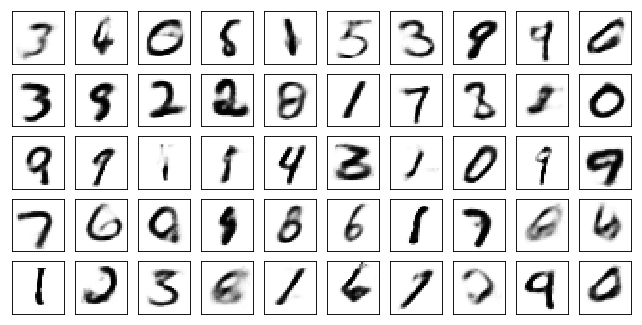

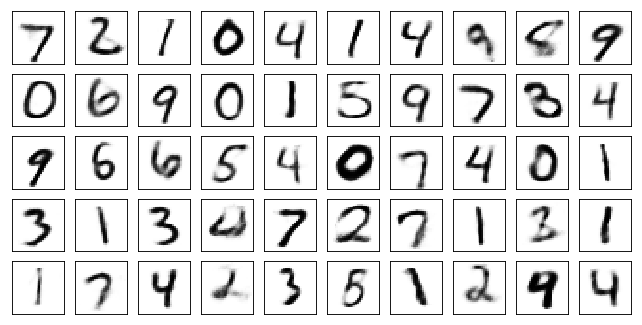

Test losses. E: 0.6965, AE: 0.0578, D: 0.6931
Train Epoch: 47 [0/50000 (0%)]	Losses E: 0.6915, AE: 0.0553, D: 0.6962
Train Epoch: 47 [5000/50000 (10%)]	Losses E: 0.6879, AE: 0.0550, D: 0.6930
Train Epoch: 47 [10000/50000 (20%)]	Losses E: 0.6944, AE: 0.0435, D: 0.6924
Train Epoch: 47 [15000/50000 (30%)]	Losses E: 0.6961, AE: 0.0574, D: 0.6985
Train Epoch: 47 [20000/50000 (40%)]	Losses E: 0.6885, AE: 0.0562, D: 0.6938
Train Epoch: 47 [25000/50000 (50%)]	Losses E: 0.6937, AE: 0.0556, D: 0.6921
Train Epoch: 47 [30000/50000 (60%)]	Losses E: 0.6955, AE: 0.0524, D: 0.6948
Train Epoch: 47 [35000/50000 (70%)]	Losses E: 0.6945, AE: 0.0577, D: 0.6902
Train Epoch: 47 [40000/50000 (80%)]	Losses E: 0.6834, AE: 0.0630, D: 0.6899
Train Epoch: 47 [45000/50000 (90%)]	Losses E: 0.6862, AE: 0.0536, D: 0.6946
Train Epoch: 47 [50000/50000 (100%)]	Losses E: 0.6844, AE: 0.0544, D: 0.6939


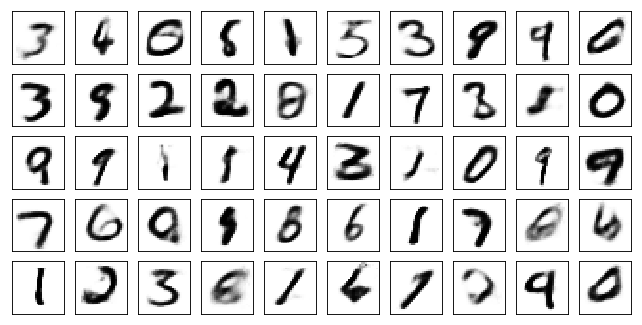

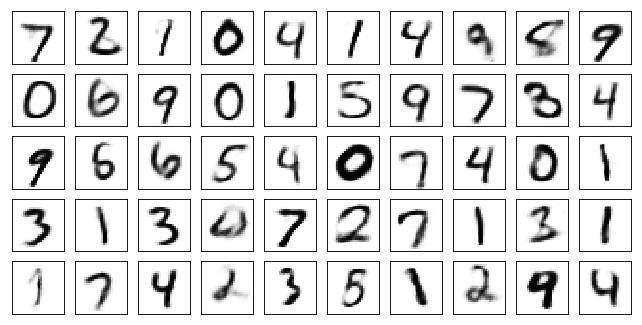

Test losses. E: 0.6872, AE: 0.0578, D: 0.6927
Train Epoch: 48 [0/50000 (0%)]	Losses E: 0.6950, AE: 0.0619, D: 0.6929
Train Epoch: 48 [5000/50000 (10%)]	Losses E: 0.6985, AE: 0.0563, D: 0.6939
Train Epoch: 48 [10000/50000 (20%)]	Losses E: 0.6920, AE: 0.0585, D: 0.6910
Train Epoch: 48 [15000/50000 (30%)]	Losses E: 0.6975, AE: 0.0474, D: 0.6960
Train Epoch: 48 [20000/50000 (40%)]	Losses E: 0.6955, AE: 0.0493, D: 0.6934
Train Epoch: 48 [25000/50000 (50%)]	Losses E: 0.6892, AE: 0.0576, D: 0.6876
Train Epoch: 48 [30000/50000 (60%)]	Losses E: 0.7005, AE: 0.0541, D: 0.6924
Train Epoch: 48 [35000/50000 (70%)]	Losses E: 0.6875, AE: 0.0586, D: 0.6926
Train Epoch: 48 [40000/50000 (80%)]	Losses E: 0.7105, AE: 0.0593, D: 0.6917
Train Epoch: 48 [45000/50000 (90%)]	Losses E: 0.7051, AE: 0.0729, D: 0.6946
Train Epoch: 48 [50000/50000 (100%)]	Losses E: 0.6880, AE: 0.0491, D: 0.6974


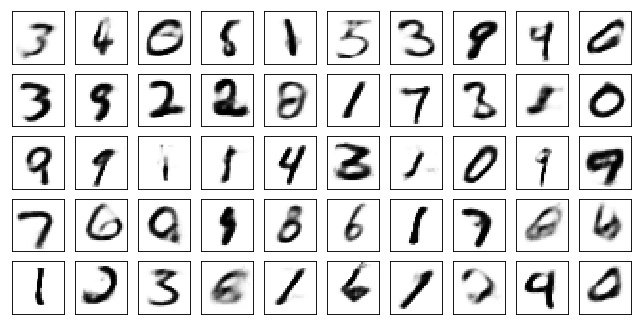

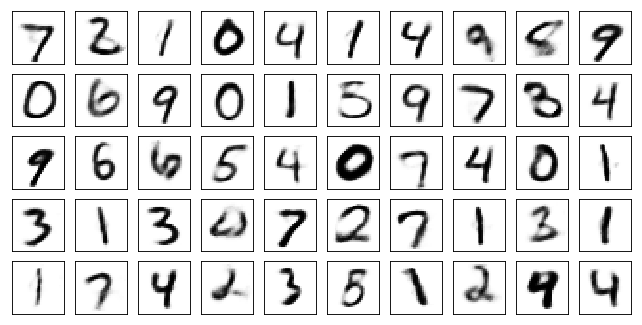

Test losses. E: 0.6894, AE: 0.0569, D: 0.6921
Train Epoch: 49 [0/50000 (0%)]	Losses E: 0.6893, AE: 0.0526, D: 0.6939
Train Epoch: 49 [5000/50000 (10%)]	Losses E: 0.7015, AE: 0.0571, D: 0.6924
Train Epoch: 49 [10000/50000 (20%)]	Losses E: 0.6936, AE: 0.0468, D: 0.6974
Train Epoch: 49 [15000/50000 (30%)]	Losses E: 0.7011, AE: 0.0555, D: 0.6929
Train Epoch: 49 [20000/50000 (40%)]	Losses E: 0.7001, AE: 0.0552, D: 0.6918
Train Epoch: 49 [25000/50000 (50%)]	Losses E: 0.6923, AE: 0.0598, D: 0.6908
Train Epoch: 49 [30000/50000 (60%)]	Losses E: 0.6946, AE: 0.0616, D: 0.6929
Train Epoch: 49 [35000/50000 (70%)]	Losses E: 0.6841, AE: 0.0552, D: 0.6922
Train Epoch: 49 [40000/50000 (80%)]	Losses E: 0.7011, AE: 0.0585, D: 0.6881
Train Epoch: 49 [45000/50000 (90%)]	Losses E: 0.7209, AE: 0.0549, D: 0.6961
Train Epoch: 49 [50000/50000 (100%)]	Losses E: 0.6997, AE: 0.0475, D: 0.6904


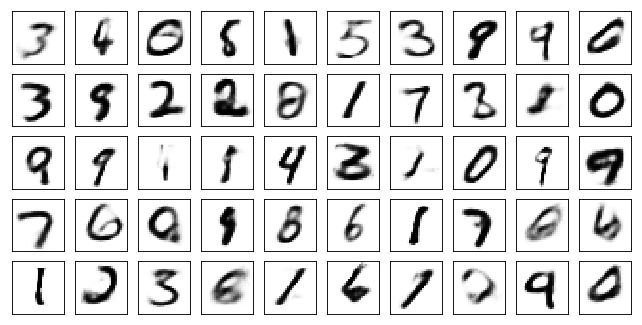

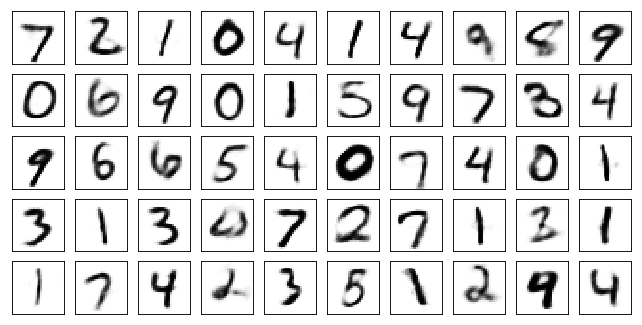

Test losses. E: 0.6950, AE: 0.0561, D: 0.6918
Train Epoch: 50 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0515, D: 0.6901
Train Epoch: 50 [5000/50000 (10%)]	Losses E: 0.6985, AE: 0.0539, D: 0.6970
Train Epoch: 50 [10000/50000 (20%)]	Losses E: 0.7004, AE: 0.0639, D: 0.6919
Train Epoch: 50 [15000/50000 (30%)]	Losses E: 0.7058, AE: 0.0527, D: 0.6906
Train Epoch: 50 [20000/50000 (40%)]	Losses E: 0.7112, AE: 0.0609, D: 0.6927
Train Epoch: 50 [25000/50000 (50%)]	Losses E: 0.6996, AE: 0.0551, D: 0.6929
Train Epoch: 50 [30000/50000 (60%)]	Losses E: 0.7035, AE: 0.0574, D: 0.6891
Train Epoch: 50 [35000/50000 (70%)]	Losses E: 0.6952, AE: 0.0468, D: 0.6906
Train Epoch: 50 [40000/50000 (80%)]	Losses E: 0.7041, AE: 0.0525, D: 0.6926
Train Epoch: 50 [45000/50000 (90%)]	Losses E: 0.6983, AE: 0.0483, D: 0.6935
Train Epoch: 50 [50000/50000 (100%)]	Losses E: 0.7010, AE: 0.0490, D: 0.6895


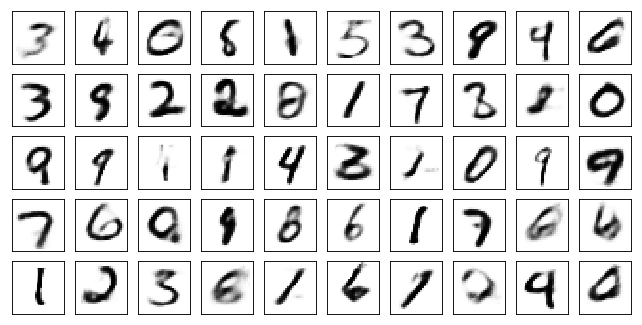

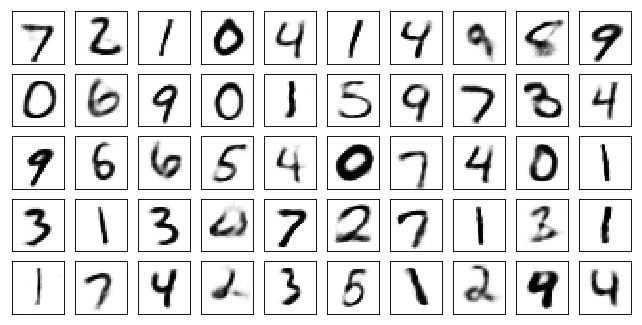

Test losses. E: 0.7017, AE: 0.0566, D: 0.6910


In [13]:
for epoch in range(1, train_epoch + 1):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)